## Helioseismology project - Part 2
*Fourier* analysis of the sun's radial oscillations:

In [1772]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit, differential_evolution
import warnings

# Matplolib style
plt.style.use('https://github.com/kaiuki2000/PitayaRemix/raw/main/PitayaRemix.mplstyle')

# # Reset matplolib style
# plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('seaborn-v0_8-pastel')

In [1773]:
# Read data and stack the pandas dataframe into a single 1d array, reading lines consecutively
data_calib1_pm1 = pd.read_table('./DataSeries/data2_calib1_pm1_960411_961010.dat', sep = '\s+', header = None).stack().values
data_calib2_pm1 = pd.read_table('./DataSeries/data2_calib2_pm1_960411_961010.dat', sep = '\s+', header = None).stack().values
data_calib1_pm2 = pd.read_table('./DataSeries/data2_calib1_pm2_960411_961010.dat', sep = '\s+', header = None).stack().values
data_calib2_pm2 = pd.read_table('./DataSeries/data2_calib2_pm2_960411_961010.dat', sep = '\s+', header = None).stack().values
# Velocities are in cm/s, I think. Not sure if this is correct, though.

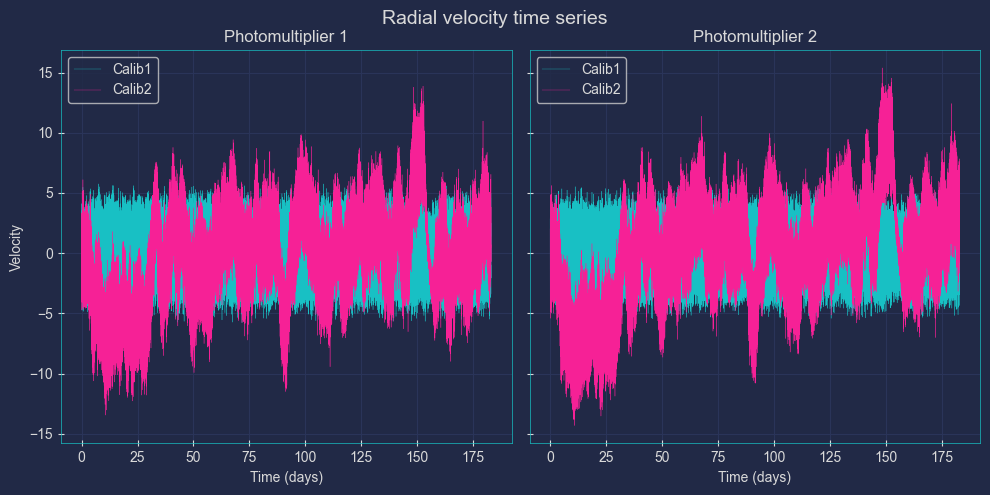

In [1872]:
# Create two subplots to plot the data
days2sec = (3600*24)
fig, ax  = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
time     = np.arange(0, len(data_calib1_pm1) * 20 / days2sec, 20 / days2sec) # Time in days. Can also use 'np.linspace'.
                                                                             # Might be better/more consistent (t_step = 20s).
# Photomultiplier 1
ax[0].plot(time, data_calib1_pm1, linewidth = 0.25)
ax[0].plot(time, data_calib2_pm1, linewidth = 0.25)
ax[0].set_title('Photomultiplier 1')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Velocity')
ax[0].legend(['Calib1', 'Calib2'], frameon = True, fancybox = True)

# Photomultiplier 2
ax[1].plot(time, data_calib1_pm2, linewidth = 0.25)
ax[1].plot(time, data_calib2_pm2, linewidth = 0.25)
ax[1].set_title('Photomultiplier 2')
ax[1].set_xlabel('Time (days)')
ax[1].legend(['Calib1', 'Calib2'], frameon = True, fancybox = True)

fig.suptitle('Radial velocity time series', fontsize = 14)
plt.tight_layout()
plt.subplots_adjust(top = 0.90)
plt.savefig('./Figures/CalibrationData.png', dpi = 300)
plt.show()

Calibration method 2 appears to have some sort of modulation to the signal, which I'm not sure we're supposed to have. Either way, I guess we are supposed to use method 2, based on what is said in Part 2 of the question paper (*Fourier* spectrum spike around $f = 0$), but I'm not sure why this is the case.

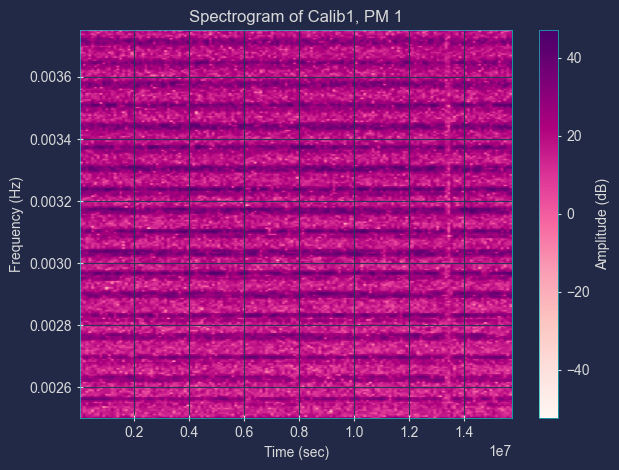

In [1821]:
# Spectrogram test
NFFT = 10184; Test_plot = plt.specgram(data_calib1_pm1, Fs = 1./20., NFFT = NFFT, noverlap = NFFT//2)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.ylim(2.5e-3, 3.75e-3)
plt.title('Spectrogram of Calib1, PM 1')
plt.colorbar(label = 'Amplitude (dB)')
plt.tight_layout()
plt.savefig('./Figures/Spectrogram.png', dpi = 300)
plt.show()

Notice the dash around 250 Hz. This is also visible below, using the regular FFT algorithm.

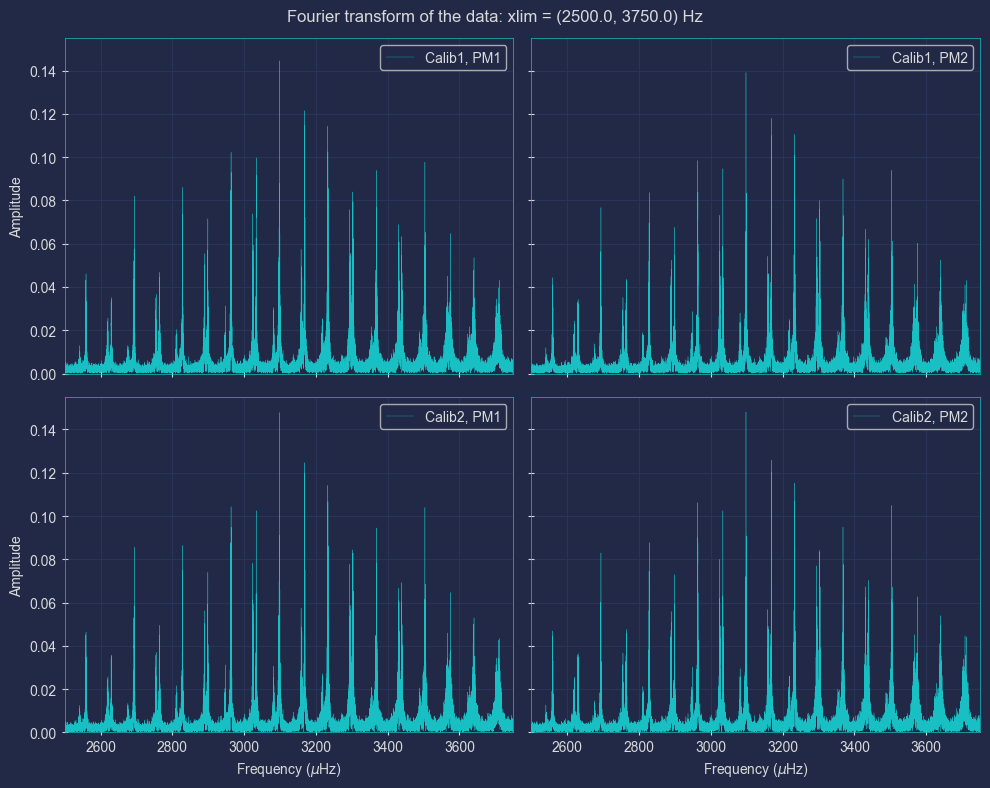

In [1846]:
# Compute fourier transform using "scipy fftpack.fft" and plot results
N       = len(data_calib1_pm1)
T       = (time[1] - time[0]) * days2sec
x       = time; xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
y11     = data_calib1_pm1; y12 = data_calib1_pm2; y21 = data_calib2_pm1; y22 = data_calib2_pm2
y11f    = scipy.fftpack.fft(y11); y12f = scipy.fftpack.fft(y12); y21f = scipy.fftpack.fft(y21); y22f = scipy.fftpack.fft(y22)

# xlim = (2e3, 4.25e3)
xlim = (2.5e3, 3.75e3)
fig, ax = plt.subplots(2, 2, figsize = (10, 8), sharex = True, sharey = True)
ax[0, 0].plot(xf*1e6, 2.0/N * np.abs(y11f[:N//2]), linewidth = 0.25, label = 'Calib1, PM1')
ax[0, 0].set_xlim(xlim)
ax[0, 0].set_ylim(0.0, 0.155)
# ax[0, 0].set_title('Calib1 - PM1')
ax[0, 0].set_ylabel('Amplitude')
ax[0, 0].legend(frameon = True, fancybox = True)

ax[0, 1].plot(xf*1e6, 2.0/N * np.abs(y12f[:N//2]), linewidth = 0.25, label = 'Calib1, PM2')
# ax[0, 1].set_title('Calib1 - PM2')
ax[0, 1].legend(frameon = True, fancybox = True)

ax[1, 0].plot(xf*1e6, 2.0/N * np.abs(y21f[:N//2]), linewidth = 0.25, label = 'Calib2, PM1')
# ax[1, 0].set_title('Calib2 - PM1')
ax[1, 0].set_xlabel(r'Frequency ($\mu$Hz)')
ax[1, 0].set_ylabel('Amplitude')
ax[1, 0].legend(frameon = True, fancybox = True)

ax[1, 1].plot(xf*1e6, 2.0/N * np.abs(y22f[:N//2]), linewidth = 0.25, label = 'Calib2, PM2')
# ax[1, 1].set_title('Calib2 - PM2')
ax[1, 1].set_xlabel(r'Frequency ($\mu$Hz)')
ax[1, 1].legend(frameon = True, fancybox = True)

fig.suptitle('Fourier transform of the data: xlim = ' + str(xlim) + ' Hz')
plt.tight_layout()
plt.savefig('./Figures/FourierTransformAll.png', dpi = 300)
plt.show()

# I still need to go through this FFT stuff, again. I'm not sure if I'm doing it right.
# Doing this analytically will help me understand, I think:
# - Sampling frequency and FFT frequency bins;
# - Nyquist frequency, etc.

In calibration method 2, there are high intensity peaks near $f = 0$. These correspond to DC components of our signal, i.e., the baseline velocity value around which the velocities oscillate is **not** zero. This can be seen in the velocity plots above.

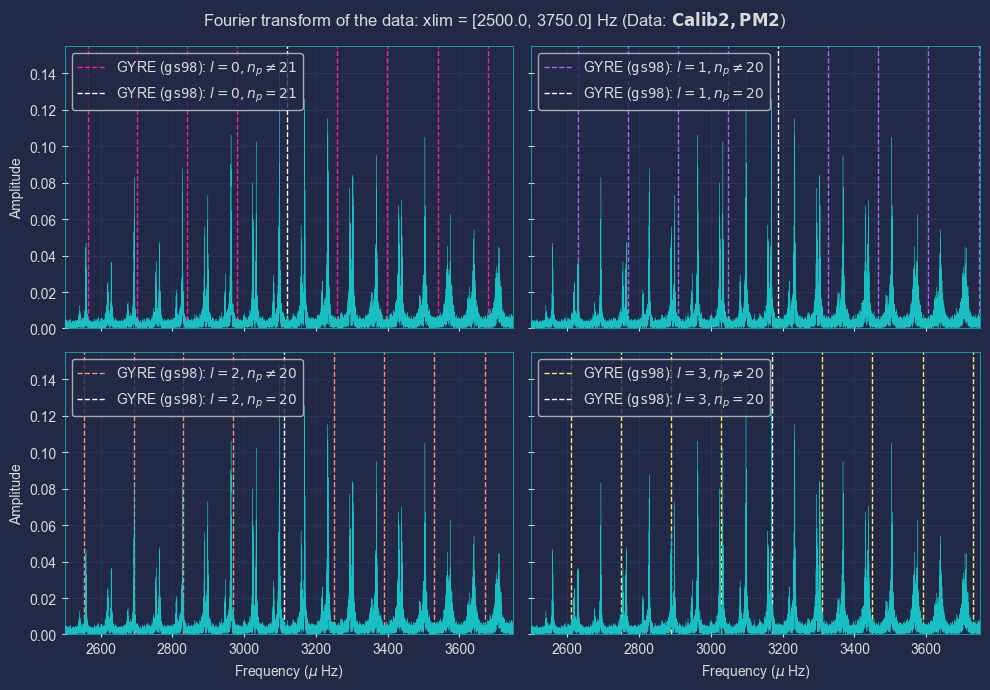

In [1843]:
# Read MESA's frequency data, computed using GYRE, from 'freqs_summary_gs98.txt'
freqs = pd.read_table('./freqs_summary_gs98_detail.txt', sep = '\s+', skiprows = 4, header = 1, \
                      dtype = {'l': 'Int64', 'n_p': 'Int64', 'n_g': 'Int64', 'n_pg': 'Int64'})

# Separate data by l and n_p
l0 = freqs[freqs['l'] == 0]; l1 = freqs[freqs['l'] == 1]; l2 = freqs[freqs['l'] == 2]; l3 = freqs[freqs['l'] == 3]
l0n21 = l0[l0['n_p'] == 21]; l1n20 = l1[l1['n_p'] == 20]; l2n20 = l2[l2['n_p'] == 20]; l3n20 = l3[l3['n_p'] == 20]
l0nx = l0[l0['n_p'] != 21];  l1nx = l1[l1['n_p'] != 20];  l2nx = l2[l2['n_p'] != 20];  l3nx = l3[l3['n_p'] != 20]

# Plotting simulation results, alongside experimental observations (from the GOLF experiment)
fig, ax = plt.subplots(2, 2, figsize = (10, 7), sharex = True, sharey = True)
ax[0, 0].vlines(l0nx['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C1', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 0, n_p \neq 21$')
ax[0, 0].vlines(l0n21['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C5', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 0, n_p = 21$')
ax[0, 0].plot(xf*1e6, 2.0/N * np.abs(y22f[:N//2]), color = 'C0', linewidth = 0.25)
ax[0, 0].set_ylabel('Amplitude')
ax[0, 0].set_xlim(xlim)
ax[0, 0].set_ylim(0.0, 0.155)
# ax[0, 0].set_title('Calib2 - PM2')
ax[0, 0].legend(frameon = True, fancybox = True)

ax[0, 1].vlines(l1nx['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C2', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 1, n_p \neq 20$')
ax[0, 1].vlines(l1n20['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C5', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 1, n_p = 20$')
ax[0, 1].plot(xf*1e6, 2.0/N * np.abs(y22f[:N//2]), color = 'C0', linewidth = 0.25)
# ax[0, 1].set_title('Calib2 - PM2')
ax[0, 1].legend(frameon = True, fancybox = True)

ax[1, 0].vlines(l2nx['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C3', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 2, n_p \neq 20$')
ax[1, 0].vlines(l2n20['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C5', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 2, n_p = 20$')
ax[1, 0].plot(xf*1e6, 2.0/N * np.abs(y22f[:N//2]), color = 'C0', linewidth = 0.25)
ax[1, 0].set_xlabel(r'Frequency ($\mu$ Hz)')
ax[1, 0].set_ylabel('Amplitude')
# ax[1, 0].set_title('Calib2 - PM2')
ax[1, 0].legend(frameon = True, fancybox = True)

ax[1, 1].vlines(l3nx['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C4', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 3, n_p \neq 20$')
ax[1, 1].vlines(l3n20['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C5', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 3, n_p = 20$')
ax[1, 1].plot(xf*1e6, 2.0/N * np.abs(y22f[:N//2]), color = 'C0', linewidth = 0.25)
ax[1, 1].set_xlabel(r'Frequency ($\mu$ Hz)')
# ax[1, 1].set_title('Calib2 - PM2')
ax[1, 1].legend(frameon = True, fancybox = True)

fig.suptitle(f'Fourier transform of the data: xlim = [{xlim[0]}, {xlim[1]}]' + r' Hz (Data: $\mathbf{Calib2, PM2}$)')
plt.tight_layout()
plt.savefig('./Figures/FourierTransform(2,2)+GYRE_Separated.png', dpi = 300)
plt.show()

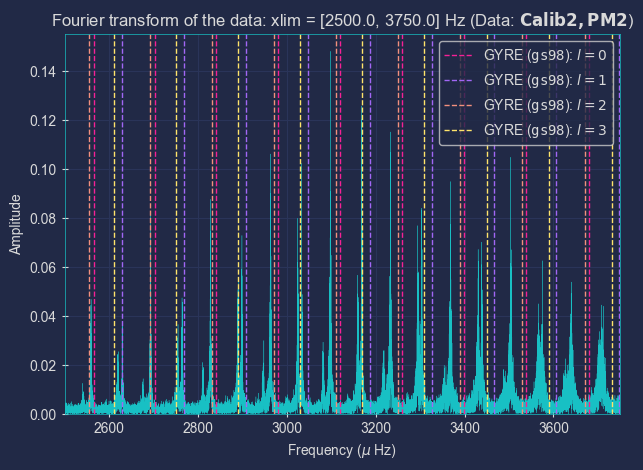

In [1850]:
# Read MESA's frequency data, computed using GYRE, from 'freqs_summary_gs98.txt'
freqs = pd.read_table('./freqs_summary_gs98_detail.txt', sep = '\s+', skiprows = 4, header = 1, \
                      dtype = {'l': 'Int64', 'n_p': 'Int64', 'n_g': 'Int64', 'n_pg': 'Int64'})

# Separate data by l and n_p
l0 = freqs[freqs['l'] == 0]; l1 = freqs[freqs['l'] == 1]; l2 = freqs[freqs['l'] == 2]; l3 = freqs[freqs['l'] == 3]

# Plotting simulation results, alongside experimental observations (from the GOLF experiment)
plt.plot(xf*1e6, 2.0/N * np.abs(y22f[:N//2]), color = 'C0', linewidth = 0.25)
plt.vlines(l0['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C1', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 0$')
plt.vlines(l1['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C2', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 1$')
plt.vlines(l2['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C3', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 2$')
plt.vlines(l3['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C4', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 3$')
plt.xlim(xlim)
plt.ylim(0.0, 0.155)
plt.xlabel(r'Frequency ($\mu$ Hz)')
plt.ylabel('Amplitude')
plt.title(f'Fourier transform of the data: xlim = [{xlim[0]}, {xlim[1]}]' + r' Hz (Data: $\mathbf{Calib2, PM2}$)')
plt.legend(frameon = True, fancybox = True)
plt.tight_layout()
plt.savefig('./Figures/FourierTransform(2,2)+GYRE_Together.png', dpi = 300)
plt.show()

[MESA/GYRE] Average large separation (Sun) = 141.14133985725056 uHz.
[MESA/GYRE] Average small separation (Sun) = 73.31404726061413 uHz.
No xlim set.


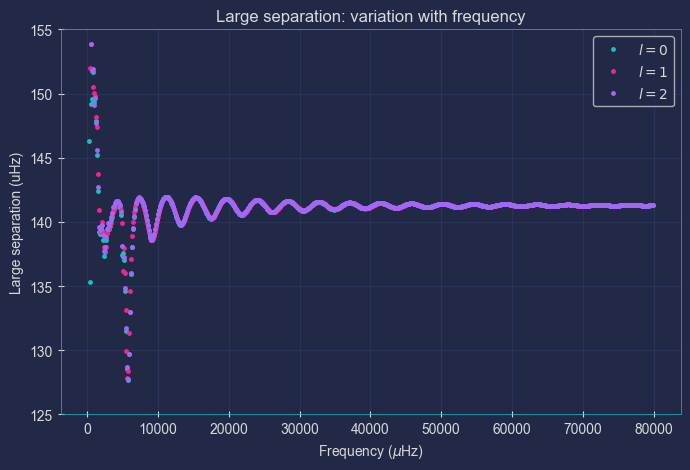

No xlim set.


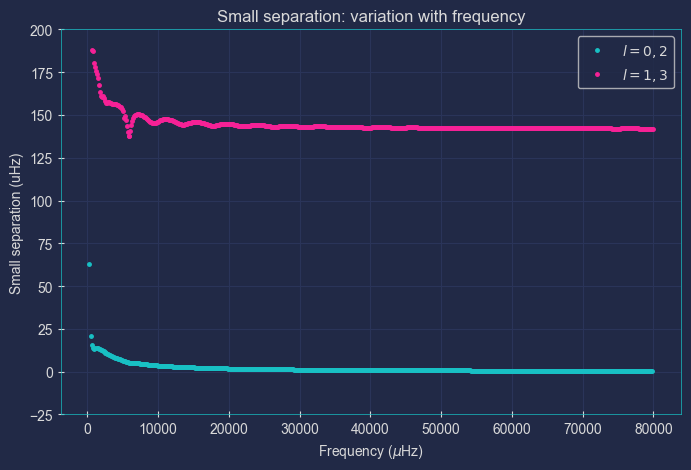

In [1865]:
class Stellar_freqs:
    """
    Class to handle stellar frequency data.
    """

    # Constructor
    def __init__(self, freqs):
        self.freqs = freqs
        self.large_sep = self.get_large_sep()
        self.small_sep = self.get_small_sep()

    # String representation
    def __str__(self) -> str:
        return f'[MESA/GYRE] Average large separation (Sun) = {np.mean(self.large_sep)} uHz.\n\
[MESA/GYRE] Average small separation (Sun) = {self.small_sep} uHz.'

    # Class methods
    # Auxiliary method to return the frequency of a given mode,
    # given its angular number (l) and radial order, number o shells (n_p).
    def get_freq(self, l, n_p) -> float:
        """
        Returns the frequency of a given mode, given its angular number (l) and radial order, number o shells (n_p).
        """
        returned_freqs = self.freqs[(self.freqs['l'] == l) & (self.freqs['n_p'] == n_p)]['Re(freq)'].values
        if(len(returned_freqs) > 1): return np.mean(returned_freqs)
        else: return returned_freqs[0]

    # Returns uncertainty of a certain n, l mode.
    def get_err(self, l, n_p) -> float:
        """
        Returns the error/uncertainty of a given mode, given its angular number (l) and radial order, number o shells (n_p).
        """
        return self.freqs[(self.freqs['l'] == l) & (self.freqs['n_p'] == n_p)]['Re(freq)_Err'].values[0]
    
    # Large separation
    def get_large_sep(self) -> float:
        """
        Returns the large separation for a given star, given its frequency data.
        """
        large_sep = np.array([])
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l'])):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p'])):
                try:
                    large_sep = np.append(large_sep, self.get_freq(l, n+1) - self.get_freq(l, n))
                except IndexError:
                    pass
        return np.mean(large_sep)

    # Small separation
    def get_small_sep(self) -> float:
        """
        Returns the small separation for a given star, given its frequency data.
        """
        small_sep = np.array([])
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l'])):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p'])):
                try:
                    small_sep = np.append(small_sep, self.get_freq(l, n) - self.get_freq(l+2, n-1))
                except IndexError:
                    pass
        return np.mean(small_sep)
    
    # Plotting methods
    # Large separation as a function of frequency.
    def large_sep_plot(self, **kwargs):
        """
        Plots the large separation for a given star, given its frequency data.
        """
        large_sep = []
        if('Re(freq)_Err' in self.freqs.columns): error_bars = []
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l'])):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p'])):
                try:
                    large_sep.append((self.get_freq(l, n+1) - self.get_freq(l, n), n, l))
                    if('Re(freq)_Err' in self.freqs.columns): error_bars.append(np.sqrt(self.get_err(l, n+1)**2 + self.get_err(l, n)**2))
                except IndexError:
                    pass

        # Auxiliary lists, for aiding in plotting
        large_sep_l0 = [tuple for tuple in large_sep if tuple[2] == 0]; l0 = self.freqs[self.freqs['l'] == 0]
        large_sep_l1 = [tuple for tuple in large_sep if tuple[2] == 1]; l1 = self.freqs[self.freqs['l'] == 1]
        large_sep_l2 = [tuple for tuple in large_sep if tuple[2] == 2]; l2 = self.freqs[self.freqs['l'] == 2]
        y_l0 = [(freq[0], freq[1]) for freq in large_sep_l0]; y_l1 = [(freq[0], freq[1]) for freq in large_sep_l1]
        y_l2 = [(freq[0], freq[1]) for freq in large_sep_l2]

        large_sep_l0_x = [l0[l0['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in large_sep_l0]
        try: large_sep_l0_x_Err = [l0[l0['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in large_sep_l0]
        except KeyError: pass
        large_sep_l1_x = [l1[l1['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in large_sep_l1]
        try: large_sep_l1_x_Err = [l1[l1['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in large_sep_l1]
        except KeyError: pass
        large_sep_l2_x = [l2[l2['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in large_sep_l2]
        try: large_sep_l2_x_Err = [l2[l2['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in large_sep_l2]
        except KeyError: pass

        fig, ax = plt.subplots(figsize = (8, 5))
        ax.plot(large_sep_l0_x, [freq[0] for freq in large_sep_l0], 'o', markersize = 2.5, color = 'C0', label = r'$l = 0$')
        ax.plot(large_sep_l1_x, [freq[0] for freq in large_sep_l1], 'o', markersize = 2.5, color = 'C1', label = r'$l = 1$')
        ax.plot(large_sep_l2_x, [freq[0] for freq in large_sep_l2], 'o', markersize = 2.5, color = 'C2', label = r'$l = 2$')
        if('Re(freq)_Err' in self.freqs.columns):
            # Auxiliary lists, for aiding in plotting the error bars
            error_bars_l0 = [error_bars[i] for i in range(len(error_bars)) if large_sep[i][2] == 0]
            error_bars_l1 = [error_bars[i] for i in range(len(error_bars)) if large_sep[i][2] == 1]
            error_bars_l2 = [error_bars[i] for i in range(len(error_bars)) if large_sep[i][2] == 2]
            # Plotting error bars: both x and y.
            try: ax.errorbar(large_sep_l0_x, [freq[0] for freq in large_sep_l0], xerr = np.array(large_sep_l0_x_Err)*100, yerr = np.array(error_bars_l0)*100, fmt = 'none', ecolor = 'C0', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(large_sep_l0_x, [freq[0] for freq in large_sep_l0], yerr = np.array(error_bars_l0)*100, fmt = 'none', ecolor = 'C0', label = r'$100 \times \sigma$', alpha = 0.5)
            try: ax.errorbar(large_sep_l1_x, [freq[0] for freq in large_sep_l1], xerr = np.array(large_sep_l1_x_Err)*100, yerr = np.array(error_bars_l1)*100, fmt = 'none', ecolor = 'C1', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(large_sep_l1_x, [freq[0] for freq in large_sep_l1], yerr = np.array(error_bars_l1)*100, fmt = 'none', ecolor = 'C1', label = r'$100 \times \sigma$', alpha = 0.5)
            try: ax.errorbar(large_sep_l2_x, [freq[0] for freq in large_sep_l2], xerr = np.array(large_sep_l2_x_Err)*100, yerr = np.array(error_bars_l2)*100, fmt = 'none', ecolor = 'C2', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(large_sep_l2_x, [freq[0] for freq in large_sep_l2], yerr = np.array(error_bars_l2)*100, fmt = 'none', ecolor = 'C2', label = r'$100 \times \sigma$', alpha = 0.5)
            ax.legend(ncol = 2, frameon = True, fancybox = True)
        else:
            ax.legend(frameon = True, fancybox = True)
        ax.set_xlabel(r'Frequency ($\mu$Hz)')
        ax.set_ylabel('Large separation (uHz)')

        # Title setting
        try: ax.set_title(kwargs['title'])
        except KeyError: ax.set_title('Large separation: variation with frequency')

        # Limit setting
        try: ax.set_xlim(kwargs['xlim'])
        except KeyError: print('No xlim set.'); pass
        try: ax.set_ylim(kwargs['ylim'])
        except KeyError: print('No ylim set.'); pass
        try: plt.savefig(f'./Figures/LargeSeparation_' + kwargs['append_name'] + '.png', dpi = 300)
        except KeyError: plt.savefig('./Figures/LargeSeparation.png', dpi = 300)
        plt.show()

        # Return the small separation for l = 0, l = 1, l = 2.
        try: return y_l0, y_l1, y_l2
        except NameError: pass

     # Small separation as a function of frequency.
    def small_sep_plot(self, **kwargs):
        """
        Plots the small separation for a given star, given its frequency data.
        """
        small_sep = []
        if('Re(freq)_Err' in self.freqs.columns): error_bars = []
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l'])):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p'])):
                try:
                    small_sep.append((self.get_freq(l, n) - self.get_freq(l+2, n-1), n, l))
                    if('Re(freq)_Err' in self.freqs.columns): error_bars.append(np.sqrt(self.get_err(l, n)**2 + self.get_err(l+2, n-1)**2))
                except IndexError:
                    pass

        # Auxiliary lists, for aiding in plotting
        small_sep_l0 = [tuple for tuple in small_sep if tuple[2] == 0]; l0 = self.freqs[self.freqs['l'] == 0]
        small_sep_l1 = [tuple for tuple in small_sep if tuple[2] == 1]; l1 = self.freqs[self.freqs['l'] == 1]
        y_l0 = np.array([(freq[0], freq[1]) for freq in small_sep_l0]); y_l1 = np.array([(freq[0], freq[1]) for freq in small_sep_l1])

        small_sep_l0_x = [l0[l0['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in small_sep_l0]
        try: small_sep_l0_x_Err = [l0[l0['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in small_sep_l0]
        except KeyError: pass
        small_sep_l1_x = [l1[l1['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in small_sep_l1]
        try: small_sep_l1_x_Err = [l1[l1['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in small_sep_l1]
        except KeyError: pass

        fig, ax = plt.subplots(figsize = (8, 5))
        ax.plot(small_sep_l0_x, [freq[0] for freq in small_sep_l0], 'o', markersize = 2.5, color = 'C0', label = r'$l = 0, 2$')
        ax.plot(small_sep_l1_x, [freq[0] for freq in small_sep_l1], 'o', markersize = 2.5, color = 'C1', label = r'$l = 1, 3$')
        if('Re(freq)_Err' in self.freqs.columns):
            # Auxiliary lists, for aiding in plotting the error bars
            error_bars_l0 = [error_bars[i] for i in range(len(error_bars)) if small_sep[i][2] == 0]
            error_bars_l1 = [error_bars[i] for i in range(len(error_bars)) if small_sep[i][2] == 1]
            # Plotting error bars: both x and y.
            try: ax.errorbar(small_sep_l0_x, [freq[0] for freq in small_sep_l0], xerr = np.array(small_sep_l0_x_Err)*100, yerr = np.array(error_bars_l0)*100, fmt = 'none', ecolor = 'C0', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(small_sep_l0_x, [freq[0] for freq in small_sep_l0], yerr = np.array(error_bars_l0)*100, fmt = 'none', ecolor = 'C0', label = r'$100 \times \sigma$', alpha = 0.5)
            try: ax.errorbar(small_sep_l1_x, [freq[0] for freq in small_sep_l1], xerr = np.array(small_sep_l1_x_Err)*100, yerr = np.array(error_bars_l1)*100, fmt = 'none', ecolor = 'C1', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(small_sep_l1_x, [freq[0] for freq in small_sep_l1], yerr = np.array(error_bars_l1)*100, fmt = 'none', ecolor = 'C1', label = r'$100 \times \sigma$', alpha = 0.5)
            ax.legend(ncol = 2, frameon = True, fancybox = True)
        else:
            ax.legend(frameon = True, fancybox = True)
        ax.set_xlabel(r'Frequency ($\mu$Hz)')
        ax.set_ylabel('Small separation (uHz)')

        # Title setting
        try: ax.set_title(kwargs['title'])
        except KeyError: ax.set_title('Small separation: variation with frequency')

        # Limit setting
        try: ax.set_xlim(kwargs['xlim'])
        except KeyError: print('No xlim set.'); pass
        try: ax.set_ylim(kwargs['ylim'])
        except KeyError: print('No ylim set.'); pass
        try: plt.savefig(f'./Figures/SmallSeparation_' + kwargs['append_name'] + '.png', dpi = 300)
        except KeyError: plt.savefig('./Figures/SmallSeparation.png', dpi = 300)
        plt.show()
        
        # Return the small separation for l = 0 and l = 1
        try: return y_l0, y_l1
        except NameError: pass
    
# Create an instance of the Stellar_freqs class
Freqs_MESA_obj = Stellar_freqs(freqs)
print(Freqs_MESA_obj)
_, _, _ = Freqs_MESA_obj.large_sep_plot(ylim = (125, 155), append_name = 'MESA_all')
_, _ = Freqs_MESA_obj.small_sep_plot(ylim = (-25, 200), append_name = 'MESA_all')

Now attempting the experimental data's fitting with Lorentzian functions:

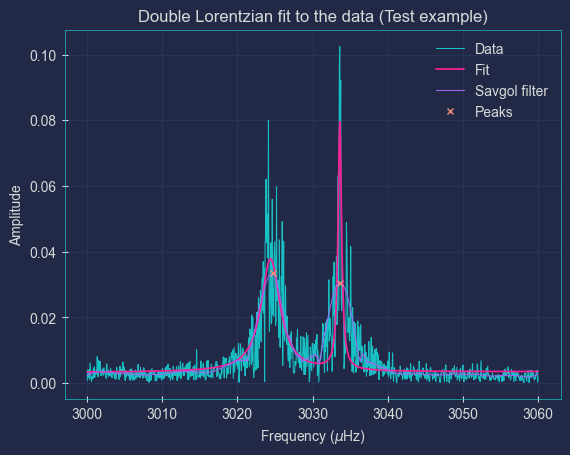

Linear off-set: a = 3.129554348643221e-06, b = -0.006090824983515719;
Peak 1: A = 0.06678811619500458, w = 0.5647819929210492, x_0 = 3033.6198002004735;
Peak 2: A1 = 0.16547031491891423, w1 = 3.0636514678920186, x_01 = 3024.409488706276.


In [1891]:
xlim_Window = (3000.0, 3060.0)
xData, yData = xf*1e6, 2.0/N * np.abs(y22f[:N//2])

yData = yData[(xData > xlim_Window[0]) & (xData < xlim_Window[1])]
xData = xData[(xData > xlim_Window[0]) & (xData < xlim_Window[1])]

# Double Lorentzian peak function
# Bounds on parameters are set in generate_Initial_Parameters() below
def double_Lorentz(x, a, b,      \
                   A, w, x_0,    \
                   A1, w1, x_01):
    """
    Double Lorentzian peak function. Parameters:
    a    - Linear off-set;
    b    - Constant off-set;
    A    - Scale factor of the first peak;
    w    - FWHM of the first peak;
    x_0  - Center of the first peak;
    A1   - Scale factor of the second peak;
    w1   - FWHM of the second peak;
    x_01 - Center of the second peak,
    """

    return a*x + b + \
           (2*A/np.pi)*(w/(4*(x-x_0)**2 + w**2)) + \
           (2*A1/np.pi)*(w1/(4*(x-x_01)**2 + w1**2))


# Function for genetic algorithm to minimize (sum of squared error)
# Bounds on parameters are set in generate_Initial_Parameters() below
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # Do not print warnings by genetic algorithm
    return np.sum((yData - double_Lorentz(xData, *parameterTuple)) ** 2)


def generate_Initial_Parameters():
    # Min and max used for bounds
    maxX = max(xData); maxY = max(yData)
    minX = min(xData); minY = min(yData)
    
    parameterBounds = []
    parameterBounds.append([-1.0, 1.0])           # Parameter bounds for a
    parameterBounds.append([maxY/-2.0, maxY/2.0]) # Parameter bounds for b

    parameterBounds.append([0.0, maxY*100.0])     # Parameter bounds for A
    parameterBounds.append([0.0, maxY*50.0])      # Parameter bounds for w
    parameterBounds.append([minX, maxX])          # Parameter bounds for x_0

    parameterBounds.append([0.0, maxY*100.0])     # Parameter bounds for A1
    parameterBounds.append([0.0, maxY*50.0])      # Parameter bounds for w1
    parameterBounds.append([minX, maxX])          # Parameter bounds for x_01

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed = 3)
    return result.x

# Load the pickled test data from original Raman spectroscopy
xData = xData
yData = yData

# Find peaks 
yhat = savgol_filter(yData, 90, 3) # window size 51, polynomial order 3
id_peaks_in_window, _ = find_peaks(yhat, prominence = 0.020)

# Generate initial parameter values
initialParameters = generate_Initial_Parameters()

# Curve fit the test data
fittedParameters, pcov = curve_fit(double_Lorentz, xData, yData, initialParameters)

# Create values for display of fitted peak function
a, b, A, w, x_0, A1, w1, x_01 = fittedParameters
y_fit = double_Lorentz(xData, *fittedParameters)

plt.plot(xData, yData, linewidth = 0.75) # Plot the raw data
plt.plot(xData, y_fit, linewidth = 1.25) # Plot the equation using the fitted parameters
plt.plot(xData, yhat, linewidth = 0.75)  # Plot the smoothed data
plt.plot(xData[id_peaks_in_window], yhat[id_peaks_in_window], 'x', color = 'C3', markersize = 5)
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Amplitude')
plt.title('Double Lorentzian fit to the data (Test example)')
plt.legend(['Data', 'Fit', 'Savgol filter', 'Peaks'])
plt.show()

print(f'Linear off-set: a = {a}, b = {b};\n\
Peak 1: A = {A}, w = {w}, x_0 = {x_0};\n\
Peak 2: A1 = {A1}, w1 = {w1}, x_01 = {x_01}.')

In [1950]:
class Progressive_Lorentz_Fitter:
    """
    Class to fit a double Lorentzian peak, progressively, to a given data set.
    """

    # Constructor
    def __init__(self, xData, yData, l0, l1, l2, l3, itSkip, window_size = 1000):
        # GOLF data ('xData', 'yData') & others
        self.xData = xData
        self.yData = yData
        self.window_size = window_size
        self.current_pos = itSkip * window_size
        self.xData_window = xData[self.current_pos:self.current_pos + self.window_size]
        self.yData_window = yData[self.current_pos:self.current_pos + self.window_size]
        self.itSkip = itSkip
        self.ctr = 0
        self.npeaks = None; self.id_peaks_in_window = None; self.yhat = None; self.find_peaks()
        self.centered = False

        # MESA/GYRE simulations frequency data
        self.l0 = l0
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3

        # Fitting variables
        self.fittedParameters = None; self.pcov = None; self.y_fit = None; self.freqs = [] # ; self.fit_window()

    # String representation
    def __str__(self) -> str:
        try:
            return f'Linear off-set: a = {self.fittedParameters[0]}, b = {self.fittedParameters[1]};\n\
Peak 1: A = {self.fittedParameters[2]}, w = {self.fittedParameters[3]}, x_0 = {self.fittedParameters[4]};\n\
Peak 2: A1 = {self.fittedParameters[5]}, w1 = {self.fittedParameters[6]}, x_01 = {self.fittedParameters[7]}.'
        except TypeError:
            return 'No fit has been performed, yet.'
    
    # Class methods
    def find_peaks(self, prominence = 0.0015, distance = 100, width = 25):
        """
        Finds the peaks in the current window.
        """
        # Savitzky-Golay filter parameters
        sav_polynomial_order = 3
        sav_window_size      = 90

        self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
        self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
        self.npeaks = len(self.id_peaks_in_window)
        if(self.npeaks == 1):
            # Shift right, so we can find the other peak (they *always* come in pairs)
            shift = 200
            self.xData_window = self.xData[self.current_pos + shift:self.current_pos + self.window_size + shift]
            self.yData_window = self.yData[self.current_pos + shift:self.current_pos + self.window_size + shift]
            self.current_pos += shift
            self.centered = False
            
            # Fit again
            self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
            self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
            self.npeaks = len(self.id_peaks_in_window)
            if(self.npeaks == 1):
                # Shift left now, so we can find the other peak (they *always* come in pairs)
                shift = 400
                self.xData_window = self.xData[self.current_pos - shift:self.current_pos + self.window_size - shift]
                self.yData_window = self.yData[self.current_pos - shift:self.current_pos + self.window_size - shift]
                self.current_pos -= shift
                self.centered = False
                
                # Fit again
                self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
                self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
                self.npeaks = len(self.id_peaks_in_window)
        if((self.npeaks == 2)):
            if(self.id_peaks_in_window[1] - self.id_peaks_in_window[0] > 450):
                # This is the case in which we are fitting two non-consecutive peaks (bad)!
                # Shift right, so we can find the other peak (they *always* come in pairs)
                shift = self.window_size//2
                self.xData_window = self.xData[self.current_pos + shift:self.current_pos + self.window_size + shift]
                self.yData_window = self.yData[self.current_pos + shift:self.current_pos + self.window_size + shift]
                self.current_pos += shift
                self.centered = False
                # Fit again
                self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
                self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
                self.npeaks = len(self.id_peaks_in_window)
                if(self.npeaks == 1):
                    # Shift left now, so we can find the other peak (they *always* come in pairs)
                    shift = self.window_size
                    self.xData_window = self.xData[self.current_pos - shift:self.current_pos + self.window_size - shift]
                    self.yData_window = self.yData[self.current_pos - shift:self.current_pos + self.window_size - shift]
                    self.current_pos -= shift
                    self.centered = False
                    # Fit again
                    self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
                    self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
                    self.npeaks = len(self.id_peaks_in_window)

    def center_peaks(self):
        """
        Centers the peaks in the current window.
        """
        if((self.npeaks == 2) & (self.centered == False)):
            # Auxiliary definitions
            avg_peak_id      = (self.id_peaks_in_window[0] + self.id_peaks_in_window[1])//2
            shift            = avg_peak_id - self.window_size//2
            
            # Shifting the window to center the peaks, so the fit is more accurate
            self.xData_window = self.xData[self.current_pos + shift:self.current_pos + self.window_size + shift]
            self.yData_window = self.yData[self.current_pos + shift:self.current_pos + self.window_size + shift]
            self.current_pos += shift

            # Update the 'centered' flag
            self.centered = True

            # Recalculate peaks' positions
            self.find_peaks()

        elif((self.npeaks == 1) & (self.centered == False)): # This will never happen now.
            pass

    def plot_window(self, SavGol = True):
        """
        Plots the current window.
        """
        # Plotting for visualisation/debugging aid
        print(f'MeanY = {np.mean(self.yData_window)}. xData_window = [{self.xData_window[0]}, {self.xData_window[-1]}].')
        xlim = (min(self.xData_window), max(self.xData_window))
        plt.plot(self.xData_window, self.yData_window, linewidth = 0.5)

        # MESA/GYRE frequency results
        for cnt, l_mode in enumerate([self.l0, self.l1, self.l2, self.l3]):
            plt.vlines(l_mode['Re(freq)'], ymin = 0.0, ymax = 0.155, color = f'C{cnt + 1}', linewidth = 1, \
                       linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): ' rf'$l = {cnt}$')
        
        # Peaks detected in the current window
        plt.plot(self.xData_window[self.id_peaks_in_window], self.yhat[self.id_peaks_in_window], \
                 "xC5", label = 'Detected peaks')

        # Plot the fitted function (if already fitted)
        if(self.fittedParameters is not None):
            plt.plot(self.xData_window, self.y_fit, label = 'Fitted function', color = 'tab:orange')

        # Plot the Savitzky-Golay filter (if desired). Helps the peak-detection algorithm.
        if(SavGol == True):
            plt.plot(self.xData_window, self.yhat, label = 'Savitzky-Golay filter', color = 'darkseagreen', linestyle = 'dashdot')

        plt.xlim(xlim)
        plt.ylim(0.0, 0.155)
        plt.xlabel(r'Frequency ($\mu$ Hz)')
        plt.ylabel('Amplitude')
        plt.title(f'Fourier transform of the data: xlim = [{xlim[0]:.2f}, {xlim[1]:.2f}]' + r' Hz (Data: $\mathbf{Calib2, Photomultiplier2}$)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def advance_window(self):
        """
        Advances the window by one step.
        """
        try:
            self.ctr += 1
            self.yData_window = self.yData[self.current_pos + self.window_size: self.current_pos + 2 * self.window_size]
            self.xData_window = self.xData[self.current_pos + self.window_size: self.current_pos + 2 * self.window_size]
            self.current_pos += self.window_size

            # Update the 'centered' flag & other variables
            self.centered = False
            self.npeaks = None; self.id_peaks_in_window = None; 
            self.y_fit = None; self.fittedParameters = None; self.pcov = None; self.find_peaks()
        except IndexError:
            self.ctr -= 1
            print('End of data reached.')

    # Fitting routine auxiliary functions:
    def fit_window(self):
        """
        Fits the current window.
        """
        if(self.npeaks == 2):
            print(f'Fitting window {self.ctr}...')
            self.center_peaks()
            # Double Lorentzian peak function
            # Bounds on parameters are set in generate_Initial_Parameters() below
            def double_Lorentz(x, a, b,      \
                               A, w, x_0,    \
                               A1, w1, x_01):
                """
                Double Lorentzian peak function. Parameters:
                a    - Linear off-set;
                b    - Constant off-set;
                A    - Scale factor of the first peak;
                w    - FWHM of the first peak;
                x_0  - Center of the first peak;
                A1   - Scale factor of the second peak;
                w1   - FWHM of the second peak;
                x_01 - Center of the second peak,
                """

                return a*x + b + \
                       (2*A/np.pi)*(w/(4*(x-x_0)**2 + w**2)) + \
                       (2*A1/np.pi)*(w1/(4*(x-x_01)**2 + w1**2))

            # Function for genetic algorithm to minimize (sum of squared error)
            # Bounds on parameters are set in generate_Initial_Parameters() below
            def sumOfSquaredError(parameterTuple):
                warnings.filterwarnings("ignore") # Do not print warnings by genetic algorithm
                return np.sum((self.yData_window - double_Lorentz(self.xData_window, *parameterTuple)) ** 2)

            def generate_Initial_Parameters():
                # Min and max used for bounds
                maxX = max(self.xData_window); maxY = max(self.yData_window)
                minX = min(self.xData_window); minY = min(self.yData_window)

                parameterBounds = []
                parameterBounds.append([-1.0, 1.0])           # Parameter bounds for a
                parameterBounds.append([maxY/-2.0, maxY/2.0]) # Parameter bounds for b

                parameterBounds.append([0.0, maxY*100.0])     # Parameter bounds for A
                parameterBounds.append([0.0, maxY*50.0])      # Parameter bounds for w
                # parameterBounds.append([minX, maxX])          # Parameter bounds for x_0
                parameterBounds.append([self.xData_window[self.id_peaks_in_window][0] - 5, 
                                        self.xData_window[self.id_peaks_in_window][0] + 5]) # Parameter bounds for x_0
                
                parameterBounds.append([0.0, maxY*100.0])     # Parameter bounds for A1
                parameterBounds.append([0.0, maxY*50.0])      # Parameter bounds for w1
                # parameterBounds.append([minX, maxX])          # Parameter bounds for x_01
                parameterBounds.append([self.xData_window[self.id_peaks_in_window][1] - 5, 
                                        self.xData_window[self.id_peaks_in_window][1] + 5]) # Parameter bounds for x_1
                
                # "seed" the numpy random number generator for repeatable results
                result = differential_evolution(sumOfSquaredError, parameterBounds)
                return result.x

            # Generate initial parameter values
            initialParameters = generate_Initial_Parameters()
    
            # Curve fit the test data
            self.fittedParameters, self.pcov = curve_fit(double_Lorentz, self.xData_window, self.yData_window, initialParameters)

            # Errors on the fitted parameters (uncertainties)
            perr = np.sqrt(np.diag(self.pcov))
            x_0_err = perr[4]; x_01_err = perr[-1]

            # Create values for display of fitted peak function
            a, b, A, w, x_0, A1, w1, x_01 = self.fittedParameters
            self.y_fit = double_Lorentz(self.xData_window, *self.fittedParameters)

            # Update the frequency array
            # Checking which radial modes are in the window (from MESA/GYRE simulations)
            l0_in = self.l0[(self.l0['Re(freq)'] > self.xData[self.current_pos]) & (l0['Re(freq)'] < self.xData[self.current_pos + self.window_size])]
            l1_in = self.l1[(self.l1['Re(freq)'] > self.xData[self.current_pos]) & (l1['Re(freq)'] < self.xData[self.current_pos + self.window_size])]
            l2_in = self.l2[(self.l2['Re(freq)'] > self.xData[self.current_pos]) & (l2['Re(freq)'] < self.xData[self.current_pos + self.window_size])]
            l3_in = self.l3[(self.l3['Re(freq)'] > self.xData[self.current_pos]) & (l3['Re(freq)'] < self.xData[self.current_pos + self.window_size])]
            if((len(l0_in) + len(l2_in) == 2) & (len(l1_in) + len(l3_in) != 2)):
                if(x_0 > x_01):
                    self.freqs.append((x_0, x_0_err, l0_in['l'].values[0], l0_in['n_p'].values[0]))
                    self.freqs.append((x_01, x_01_err, l2_in['l'].values[0], l2_in['n_p'].values[0]))
                else:
                    self.freqs.append((x_01, x_01_err, l0_in['l'].values[0], l0_in['n_p'].values[0]))
                    self.freqs.append((x_0, x_0_err, l2_in['l'].values[0], l2_in['n_p'].values[0]))
            elif((len(l1_in) + len(l3_in) == 2) & (len(l0_in) + len(l2_in) != 2)):
                if(x_0 > x_01):
                    self.freqs.append((x_0, x_0_err, l1_in['l'].values[0], l1_in['n_p'].values[0]))
                    self.freqs.append((x_01, x_01_err, l3_in['l'].values[0], l3_in['n_p'].values[0]))
                else:
                    self.freqs.append((x_01, x_01_err, l1_in['l'].values[0], l1_in['n_p'].values[0]))
                    self.freqs.append((x_0, x_0_err, l3_in['l'].values[0], l3_in['n_p'].values[0]))
            elif((len(l0_in) + len(l2_in) == 2) & (len(l1_in) + len(l3_in) == 2)):
                l0_in_freq = l0_in['Re(freq)'].values[0]; l2_in_freq = l2_in['Re(freq)'].values[0]
                l1_in_freq = l1_in['Re(freq)'].values[0]; l3_in_freq = l3_in['Re(freq)'].values[0]
                dist = np.abs(x_01 - x_0)
                dist02 = np.abs(l0_in_freq - l2_in_freq)
                dist13 = np.abs(l1_in_freq - l3_in_freq)
                if(np.abs(dist - dist02) < np.abs(dist - dist13)):
                    if(x_0 > x_01):
                        self.freqs.append((x_0, x_0_err, l0_in['l'].values[0], l0_in['n_p'].values[0]))
                        self.freqs.append((x_01, x_01_err, l2_in['l'].values[0], l2_in['n_p'].values[0]))
                    else:
                        self.freqs.append((x_01, x_01_err, l0_in['l'].values[0], l0_in['n_p'].values[0]))
                        self.freqs.append((x_0, x_0_err, l2_in['l'].values[0], l2_in['n_p'].values[0]))
                else:
                    if(x_0 > x_01):
                        self.freqs.append((x_0, x_0_err, l1_in['l'].values[0], l1_in['n_p'].values[0]))
                        self.freqs.append((x_01, x_01_err, l3_in['l'].values[0], l3_in['n_p'].values[0]))
                    else:
                        self.freqs.append((x_01, x_01_err, l1_in['l'].values[0], l1_in['n_p'].values[0]))
                        self.freqs.append((x_0, x_0_err, l3_in['l'].values[0], l3_in['n_p'].values[0]))
            else:
                print('No MESA radial modes (detected) in the current window. [Check results manually...]')
                pass

            print(f'Linear off-set: a = {a:.3e}, b = {b:.3e};\n\
Peak 1: A  = {A:.5f}, w  = {w:.5f}, x_0  = {x_0:.5f};\n\
Peak 2: A1 = {A1:.5f}, w1 = {w1:.5f}, x_01 = {x_01:.5f}.')

Fitting window 0...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = 9.906e-07, b = -3.839e-05;
Peak 1: A  = 0.00830, w  = 1.81975, x_0  = 1945.71040;
Peak 2: A1 = 0.00482, w1 = 0.47044, x_01 = 1957.44579.
MeanY = 0.002099277305896712. xData_window = [1919.9097346431258, 1983.0929545966271].


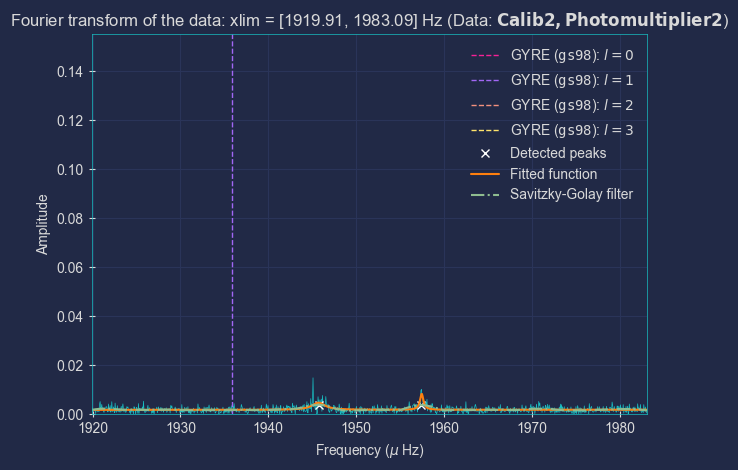

*** Separator ***



MeanY = 0.0021628855239534586. xData_window = [1970.5069077790627, 2033.690127732564].


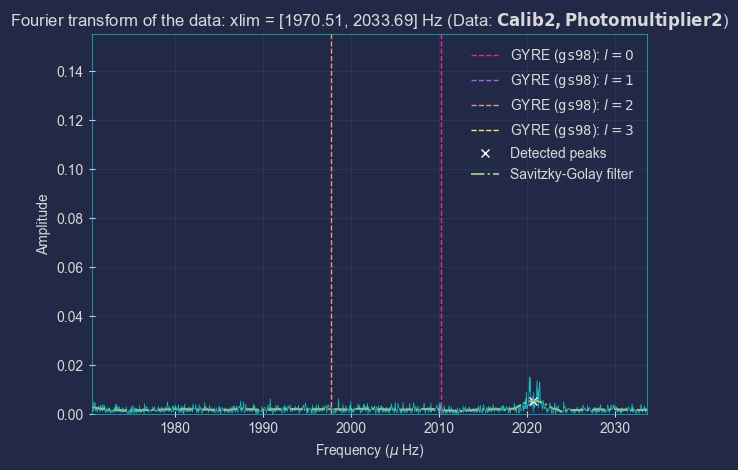

*** Separator ***



Fitting window 2...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = -1.031e-06, b = 4.004e-03;
Peak 1: A  = 0.01103, w  = 2.15534, x_0  = 2082.03641;
Peak 2: A1 = 0.00665, w1 = 0.24940, x_01 = 2093.60654.
MeanY = 0.002127906624571388. xData_window = [2056.0161303787963, 2119.1993503322974].


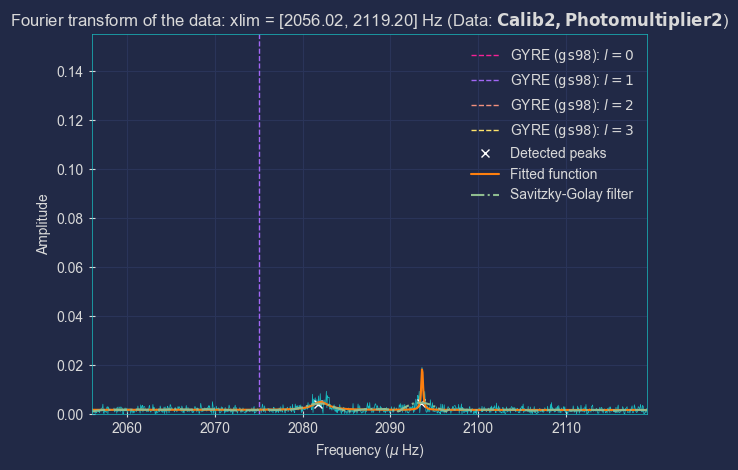

*** Separator ***



Fitting window 3...
Linear off-set: a = 7.654e-07, b = 1.858e-04;
Peak 1: A  = 0.00677, w  = 2.60758, x_0  = 2138.03414;
Peak 2: A1 = 0.02252, w1 = 1.60452, x_01 = 2156.81461.
MeanY = 0.002282837599992774. xData_window = [2115.5943017463615, 2178.777521699863].


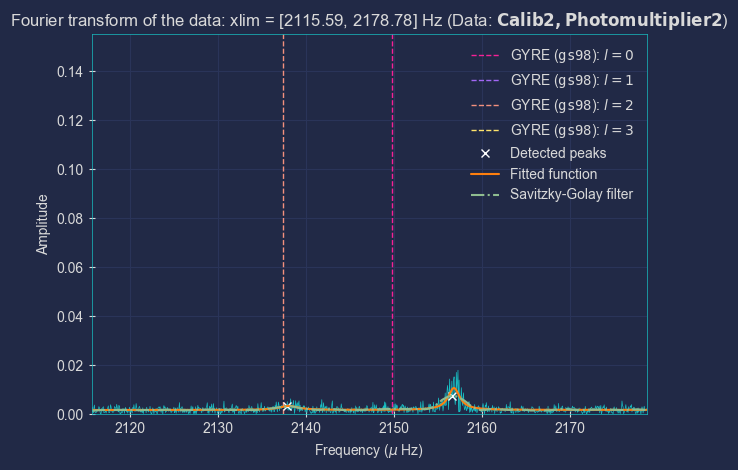

*** Separator ***



Fitting window 4...
Linear off-set: a = -4.689e-06, b = 1.225e-02;
Peak 1: A  = 0.01968, w  = 2.02246, x_0  = 2217.95658;
Peak 2: A1 = 0.01687, w1 = 1.05933, x_01 = 2228.81006.
MeanY = 0.0023954388623552217. xData_window = [2191.616554383107, 2254.799774336608].


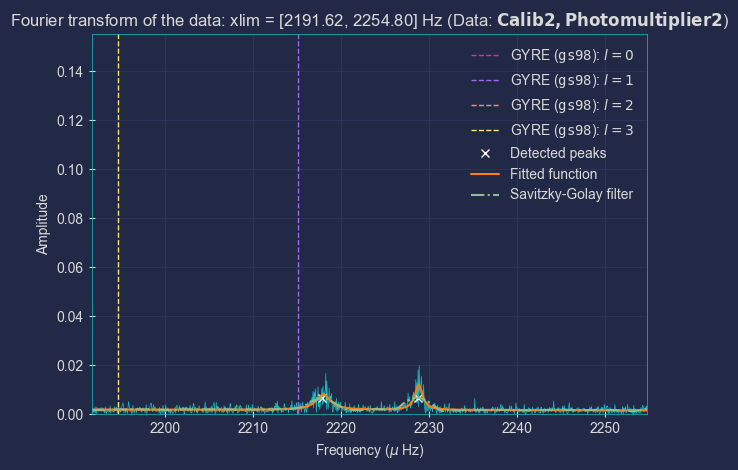

*** Separator ***



Fitting window 5...
Linear off-set: a = -2.232e-06, b = 6.907e-03;
Peak 1: A  = 0.00711, w  = 2.03103, x_0  = 2272.29008;
Peak 2: A1 = 0.03338, w1 = 1.68905, x_01 = 2291.88213.
MeanY = 0.0024400433575751442. xData_window = [2250.815246952153, 2313.9984669056544].


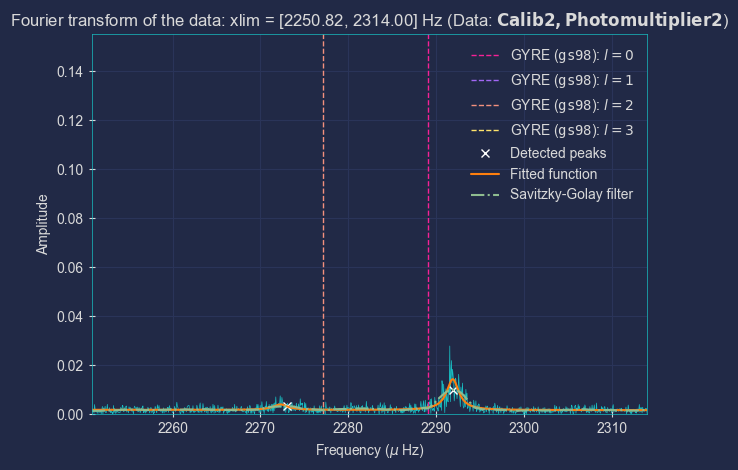

*** Separator ***



Fitting window 6...
Linear off-set: a = -3.858e-06, b = 1.099e-02;
Peak 1: A  = 0.03401, w  = 2.13740, x_0  = 2352.14639;
Peak 2: A1 = 0.02363, w1 = 1.47121, x_01 = 2362.78166.
MeanY = 0.002783554303574544. xData_window = [2325.8255561261794, 2389.008776079681].


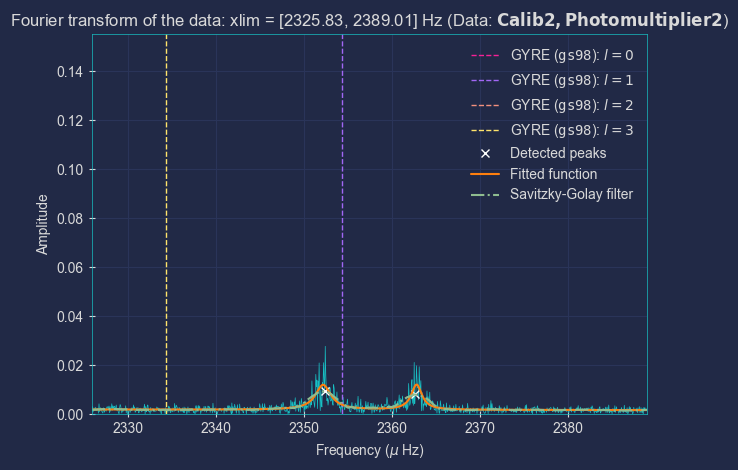

*** Separator ***



Fitting window 7...
Linear off-set: a = 4.264e-07, b = 7.832e-04;
Peak 1: A  = 0.01251, w  = 2.21395, x_0  = 2406.91513;
Peak 2: A1 = 0.05683, w1 = 2.05265, x_01 = 2425.55509.
MeanY = 0.0028847862309016566. xData_window = [2384.5815234302863, 2447.7647433837874].


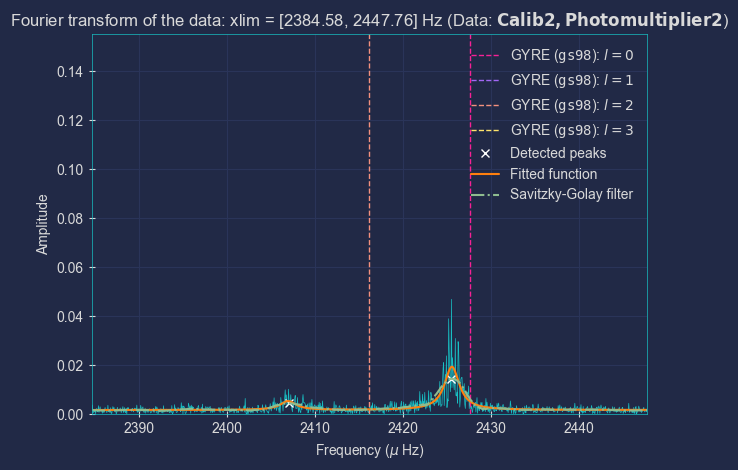

*** Separator ***



Fitting window 8...
Linear off-set: a = -6.562e-06, b = 1.829e-02;
Peak 1: A  = 0.05287, w  = 3.20162, x_0  = 2485.90684;
Peak 2: A1 = 0.03883, w1 = 1.61839, x_01 = 2496.08881.
MeanY = 0.0033553588070838573. xData_window = [2459.2123538057936, 2522.3955737592946].


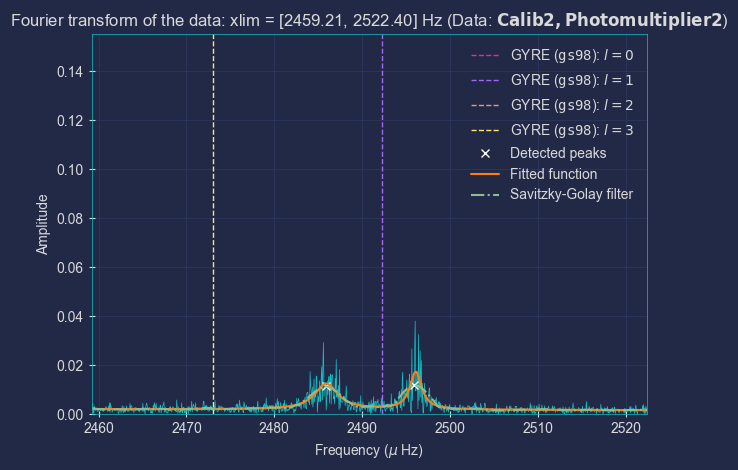

*** Separator ***



Fitting window 9...
Linear off-set: a = -9.257e-07, b = 4.199e-03;
Peak 1: A  = 0.02164, w  = 4.57395, x_0  = 2541.62234;
Peak 2: A1 = 0.08489, w1 = 2.27312, x_01 = 2559.26747.
MeanY = 0.0034716892006429662. xData_window = [2518.9170181061986, 2582.1002380597].


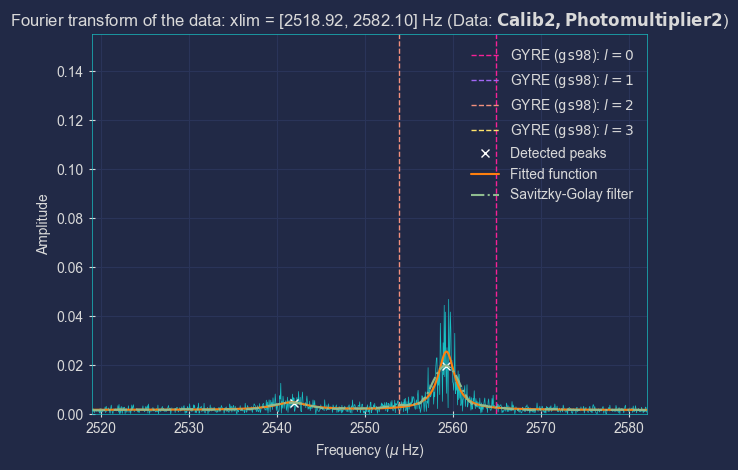

*** Separator ***



Fitting window 10...
Linear off-set: a = -3.873e-06, b = 1.208e-02;
Peak 1: A  = 0.07278, w  = 3.50187, x_0  = 2619.58356;
Peak 2: A1 = 0.06401, w1 = 2.03027, x_01 = 2629.84205.
MeanY = 0.004015249555251607. xData_window = [2593.041876750346, 2656.2250967038476].


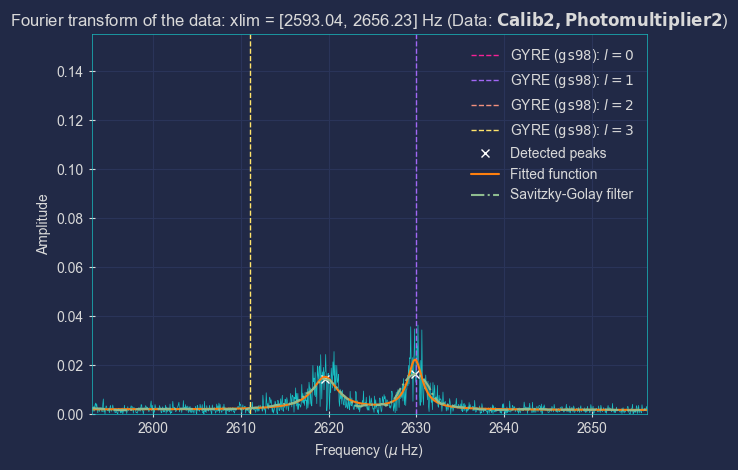

*** Separator ***



Fitting window 11...
Linear off-set: a = -5.577e-06, b = 1.673e-02;
Peak 1: A  = 0.03043, w  = 3.90522, x_0  = 2675.92915;
Peak 2: A1 = 0.13474, w1 = 2.33482, x_01 = 2693.32139.
MeanY = 0.004292437917986094. xData_window = [2652.9995269164315, 2716.182746869933].


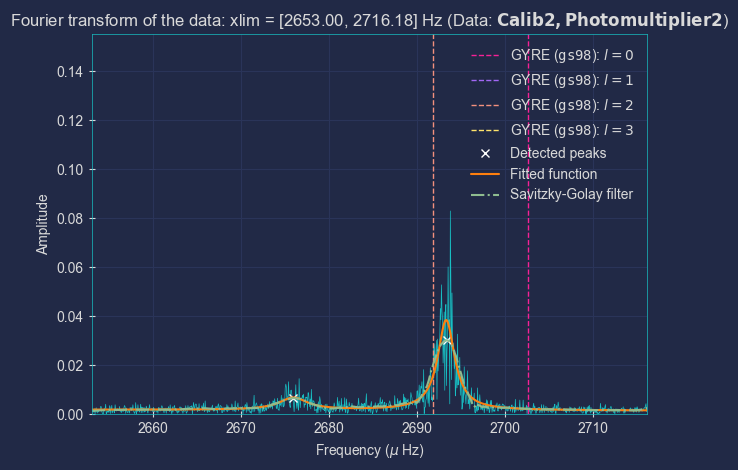

*** Separator ***



Fitting window 12...
Linear off-set: a = -6.311e-06, b = 1.936e-02;
Peak 1: A  = 0.09645, w  = 3.60724, x_0  = 2754.62747;
Peak 2: A1 = 0.08465, w1 = 2.16150, x_01 = 2764.18110.
MeanY = 0.004728673008119839. xData_window = [2727.6303572919387, 2790.81357724544].


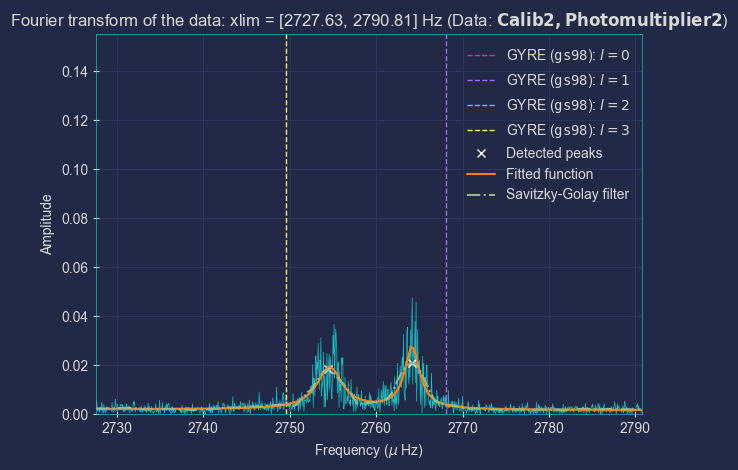

*** Separator ***



Fitting window 13...
Linear off-set: a = 6.324e-06, b = -1.559e-02;
Peak 1: A  = 0.04295, w  = 3.89933, x_0  = 2811.40511;
Peak 2: A1 = 0.14311, w1 = 2.27761, x_01 = 2828.09068.
MeanY = 0.005101054652774554. xData_window = [2788.0307327229634, 2851.213952676464].


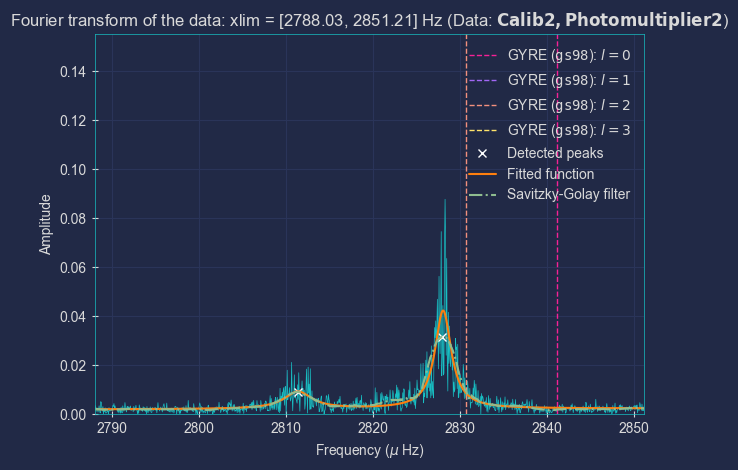

*** Separator ***



Fitting window 14...
Linear off-set: a = -1.038e-05, b = 3.247e-02;
Peak 1: A  = 0.11562, w  = 2.63197, x_0  = 2889.83332;
Peak 2: A1 = 0.09494, w1 = 1.63105, x_01 = 2898.86002.
MeanY = 0.005692409183890219. xData_window = [2862.5983166320502, 2925.7815365855513].


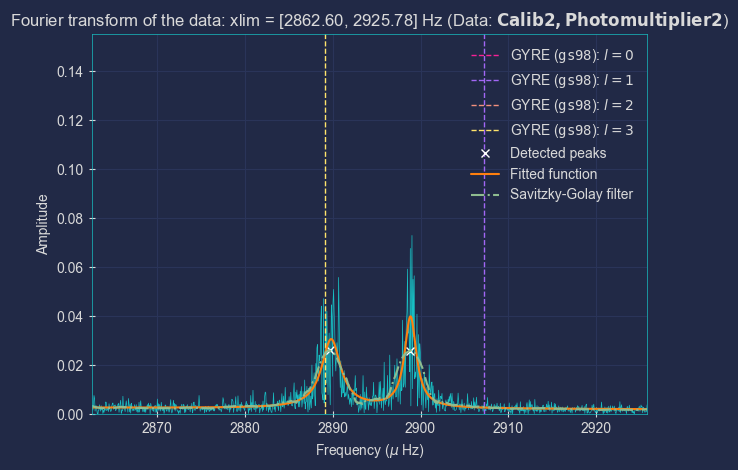

*** Separator ***



Fitting window 15...
Linear off-set: a = 6.225e-06, b = -1.609e-02;
Peak 1: A  = 0.06237, w  = 4.11802, x_0  = 2947.22206;
Peak 2: A1 = 0.19268, w1 = 2.36418, x_01 = 2963.66264.
MeanY = 0.006220991140935931. xData_window = [2923.631156727274, 2986.8143766807757].


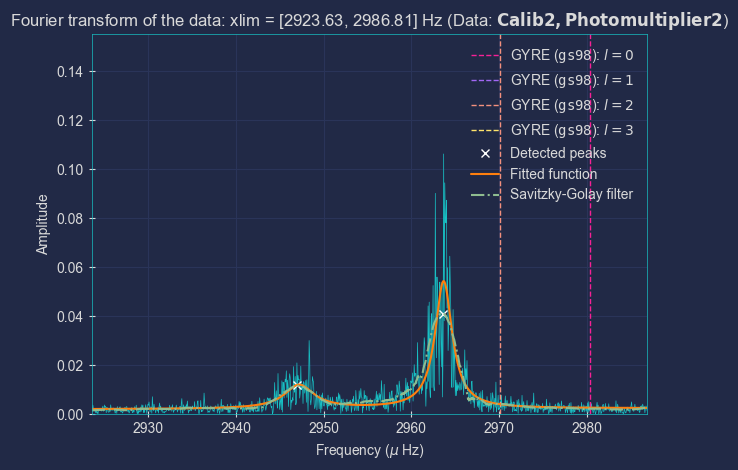

*** Separator ***



Fitting window 16...
Linear off-set: a = 1.866e-06, b = -2.298e-03;
Peak 1: A  = 0.16594, w  = 3.07170, x_0  = 3024.41046;
Peak 2: A1 = 0.06704, w1 = 0.56804, x_01 = 3033.61969.
MeanY = 0.006948109386769382. xData_window = [2997.5662759721617, 3060.7494959256633].


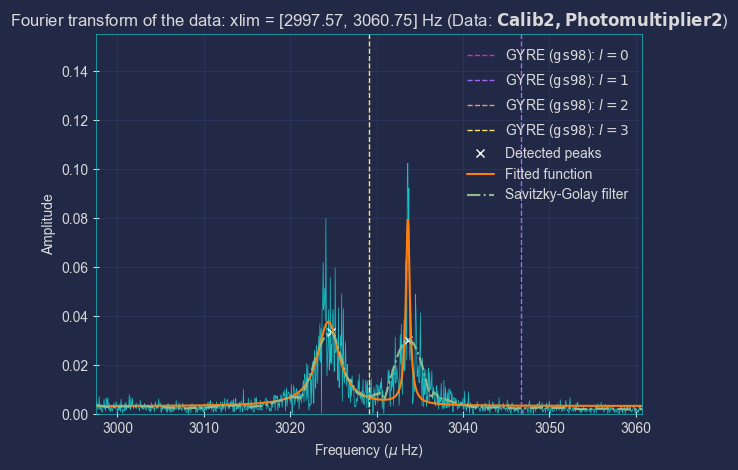

*** Separator ***



Fitting window 17...
Linear off-set: a = 3.231e-06, b = -7.821e-03;
Peak 1: A  = 0.06610, w  = 3.62229, x_0  = 3081.81930;
Peak 2: A1 = 0.23037, w1 = 3.05962, x_01 = 3098.02683.
MeanY = 0.006688087239413693. xData_window = [3058.1563908024464, 3121.3396107559474].


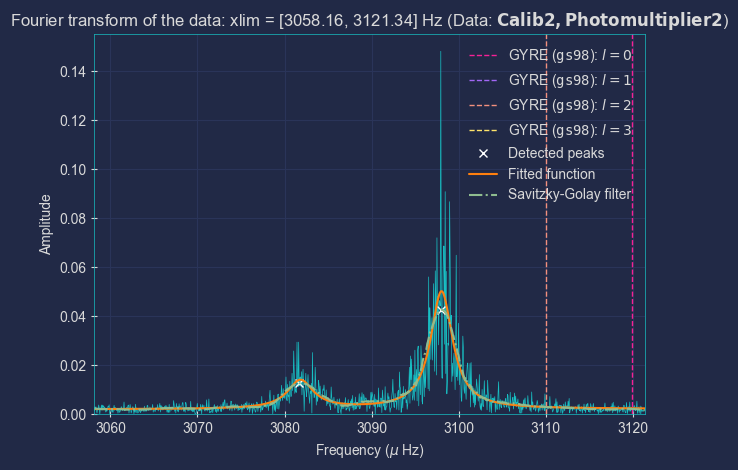

*** Separator ***



Fitting window 18...
Linear off-set: a = -5.152e-06, b = 1.895e-02;
Peak 1: A  = 0.15940, w  = 4.08753, x_0  = 3159.75782;
Peak 2: A1 = 0.15720, w1 = 1.69778, x_01 = 3168.64374.
MeanY = 0.007505374523244823. xData_window = [3132.5342353122737, 3195.717455265775].


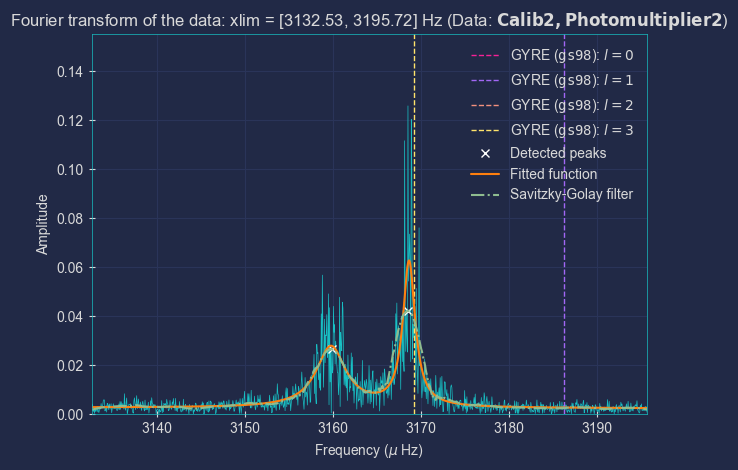

*** Separator ***



Fitting window 19...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = 5.260e-06, b = -1.439e-02;
Peak 1: A  = 0.07476, w  = 4.54935, x_0  = 3218.05806;
Peak 2: A1 = 0.25349, w1 = 3.02523, x_01 = 3233.40166.
MeanY = 0.007577306485395556. xData_window = [3193.946554206017, 3257.129774159518].


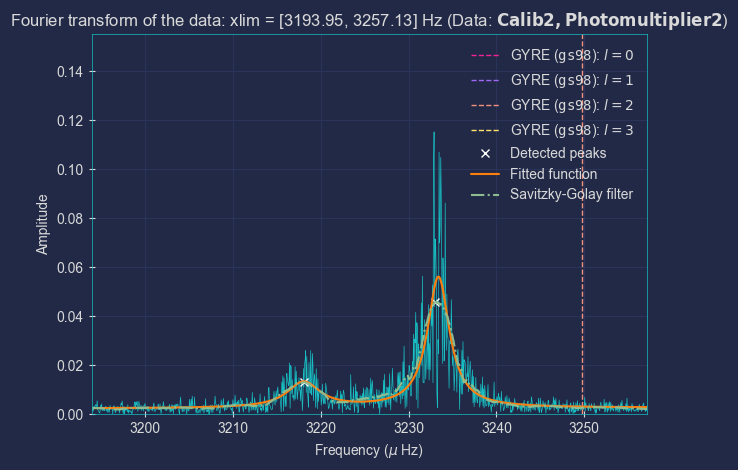

*** Separator ***



Fitting window 20...
Linear off-set: a = -8.446e-06, b = 3.067e-02;
Peak 1: A  = 0.18513, w  = 3.60219, x_0  = 3295.14452;
Peak 2: A1 = 0.15328, w1 = 2.36039, x_01 = 3303.19412.
MeanY = 0.00798838910097784. xData_window = [3267.691934051645, 3330.875154005146].


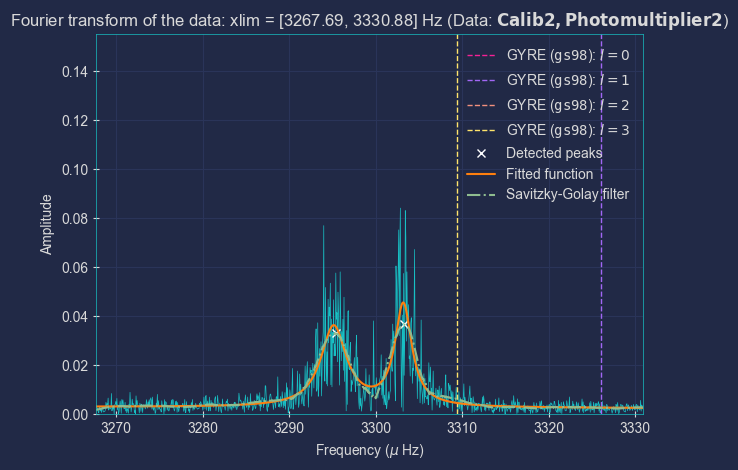

*** Separator ***



Fitting window 21...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = 3.386e-06, b = -8.447e-03;
Peak 1: A  = 0.06066, w  = 5.71811, x_0  = 3354.31698;
Peak 2: A1 = 0.20997, w1 = 2.99551, x_01 = 3368.74893.
MeanY = 0.007050540959484481. xData_window = [3329.6734711431677, 3392.8566910966692].


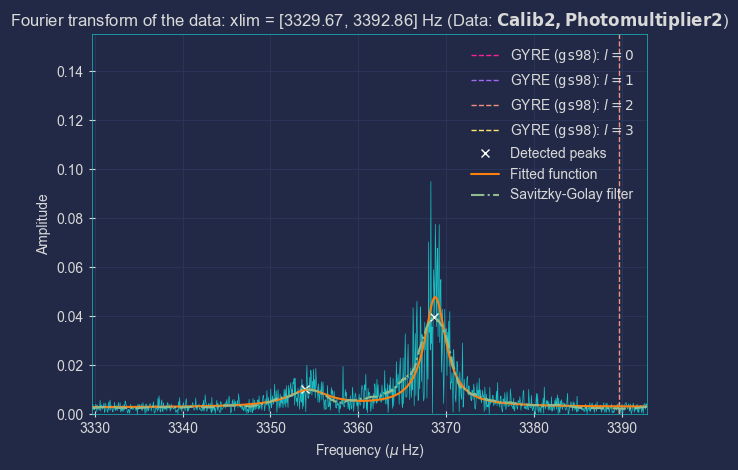

*** Separator ***



Fitting window 22...
Linear off-set: a = -1.241e-05, b = 4.557e-02;
Peak 1: A  = 0.17184, w  = 3.87267, x_0  = 3430.86262;
Peak 2: A1 = 0.15492, w1 = 3.25508, x_01 = 3438.88248.
MeanY = 0.007940136679278122. xData_window = [3403.229111589536, 3466.4123315430375].


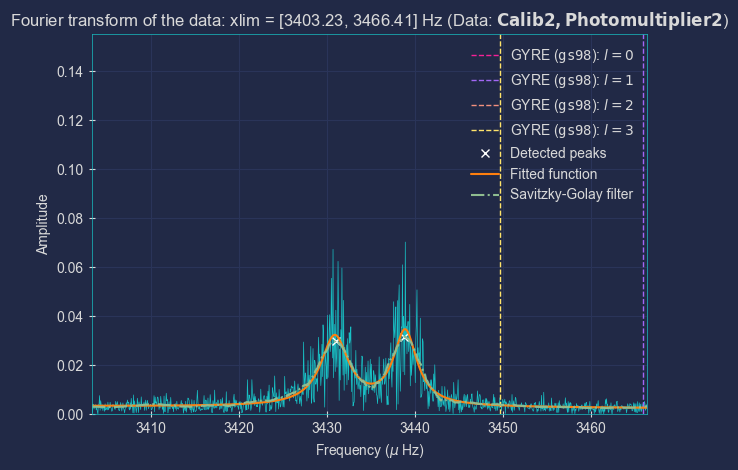

*** Separator ***



Fitting window 23...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = 9.903e-06, b = -3.185e-02;
Peak 1: A  = 0.06595, w  = 8.57296, x_0  = 3489.90766;
Peak 2: A1 = 0.22185, w1 = 4.35695, x_01 = 3503.67074.
MeanY = 0.007073116639387432. xData_window = [3464.5781840168593, 3527.7614039703603].


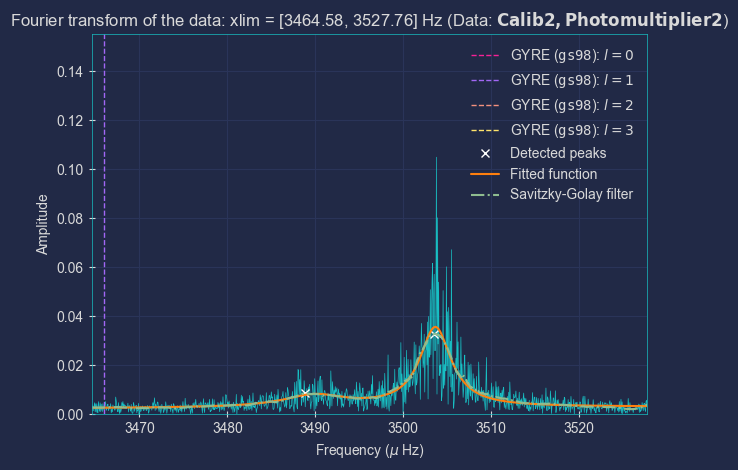

*** Separator ***



Fitting window 24...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = -5.995e-06, b = 2.426e-02;
Peak 1: A  = 0.17162, w  = 6.97235, x_0  = 3566.75720;
Peak 2: A1 = 0.12109, w1 = 4.73635, x_01 = 3574.70479.
MeanY = 0.007191875498213482. xData_window = [3539.019274993107, 3602.202494946608].


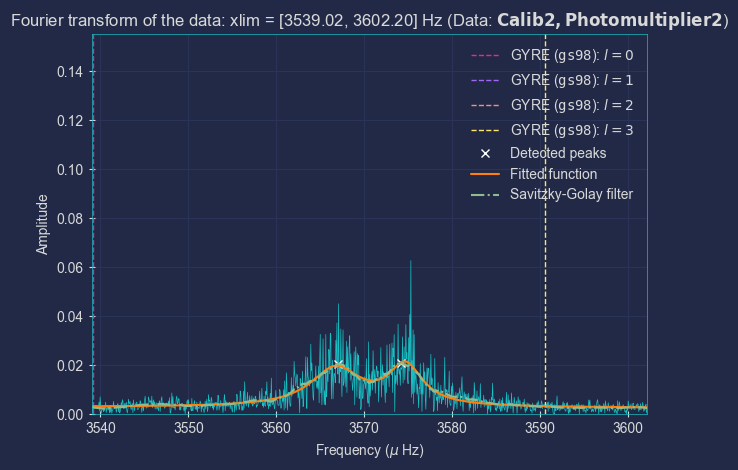

*** Separator ***



MeanY = 0.0066056701473192385. xData_window = [3589.616448129044, 3652.799668082545].


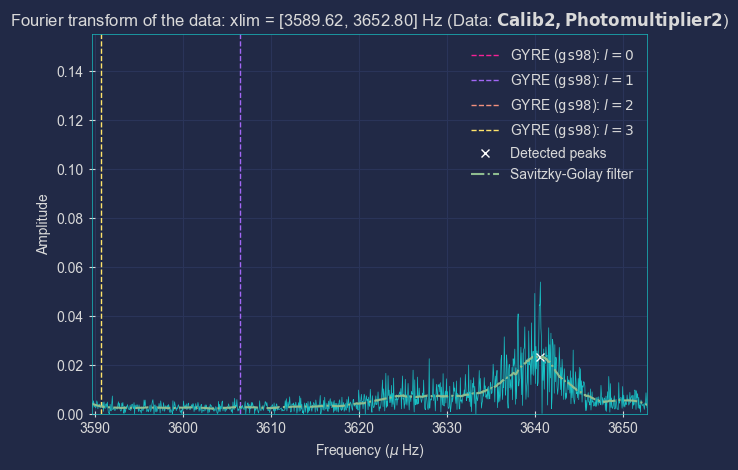

*** Separator ***



Fitting window 26...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = -1.135e-05, b = 4.437e-02;
Peak 1: A  = 0.08366, w  = 5.08791, x_0  = 3702.07105;
Peak 2: A1 = 0.24517, w1 = 10.66176, x_01 = 3709.85761.
MeanY = 0.0070120300266994775. xData_window = [3673.923987866798, 3737.1072078202997].


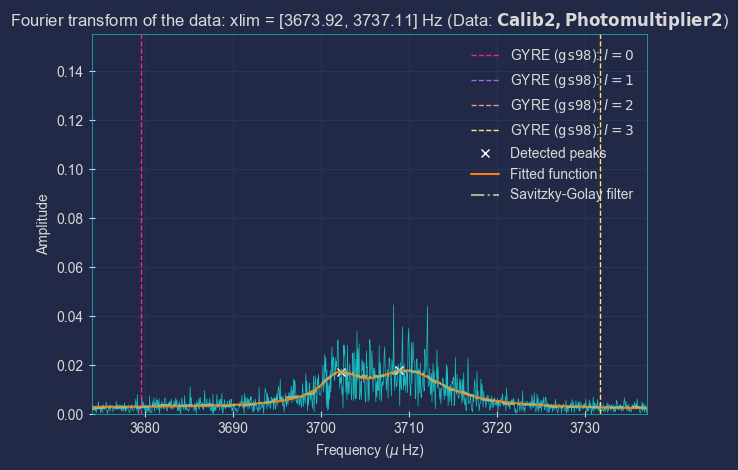

*** Separator ***



MeanY = 0.006323231165472629. xData_window = [3724.521161002735, 3787.7043809562365].


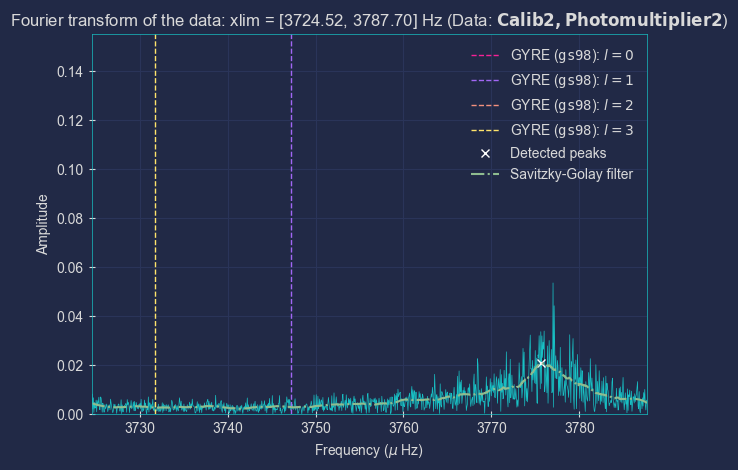

*** Separator ***



Fitting window 28...
Linear off-set: a = 6.645e-06, b = -2.261e-02;
Peak 1: A  = 0.12690, w  = 8.98704, x_0  = 3838.31168;
Peak 2: A1 = 0.11772, w1 = 7.40263, x_01 = 3847.37087.
MeanY = 0.006463516914227017. xData_window = [3810.662848266668, 3873.8460682201694].


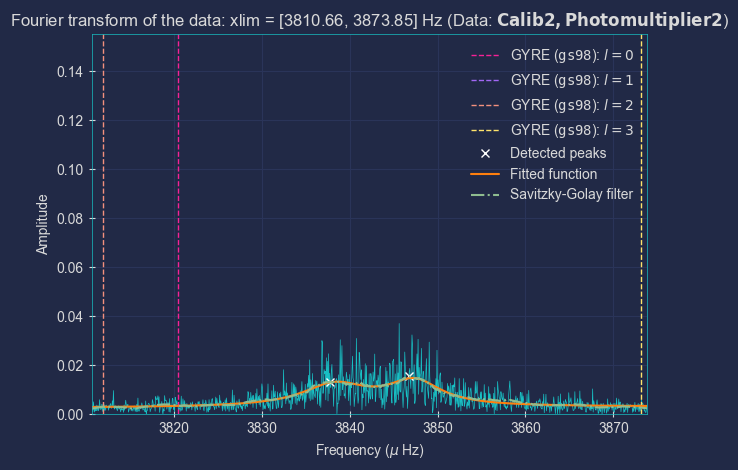

*** Separator ***



MeanY = 0.00609327271763086. xData_window = [3861.260021402605, 3924.443241356106].


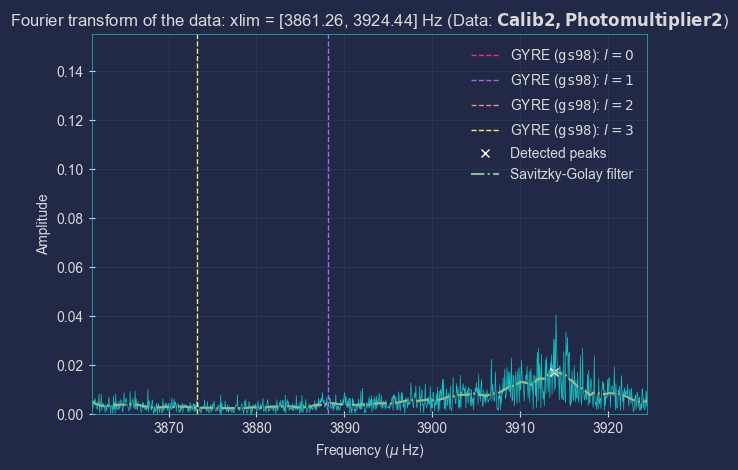

*** Separator ***



Fitting window 30...
Linear off-set: a = -1.250e-05, b = 5.152e-02;
Peak 1: A  = 0.31090, w  = 19.74204, x_0  = 3981.56218;
Peak 2: A1 = 0.00520, w1 = 0.37131, x_01 = 3984.14124.
MeanY = 0.005817955974938319. xData_window = [3948.0341733307364, 4011.217393284238].


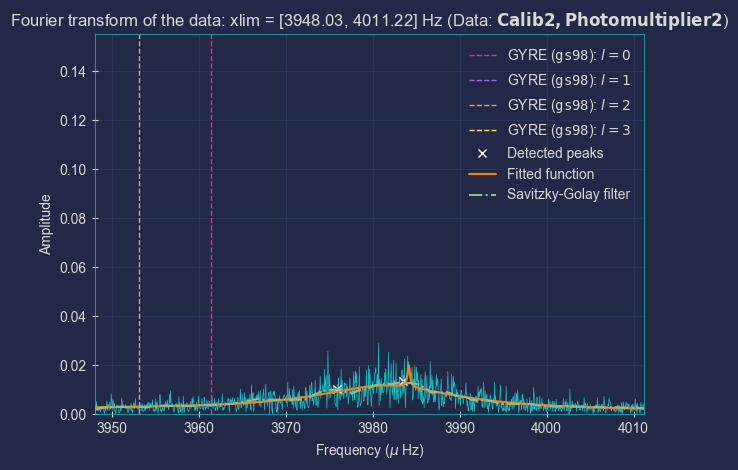

*** Separator ***



MeanY = 0.00554268899144045. xData_window = [3998.6313464666737, 4061.814566420175].


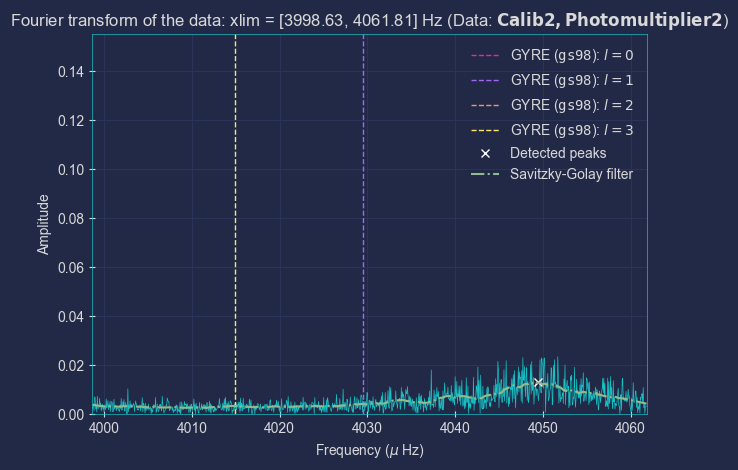

*** Separator ***



MeanY = 0.005039596065150839. xData_window = [4049.22851960261, 4112.411739556112].


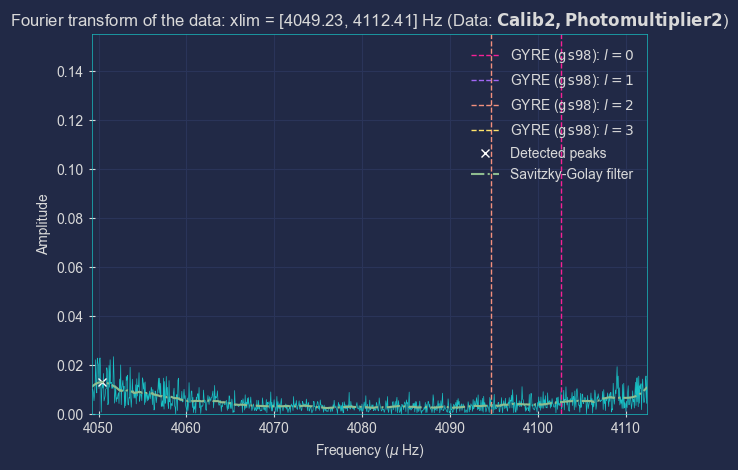

*** Separator ***



MeanY = 0.005577906790990367. xData_window = [4080.851752812571, 4144.034972766072].


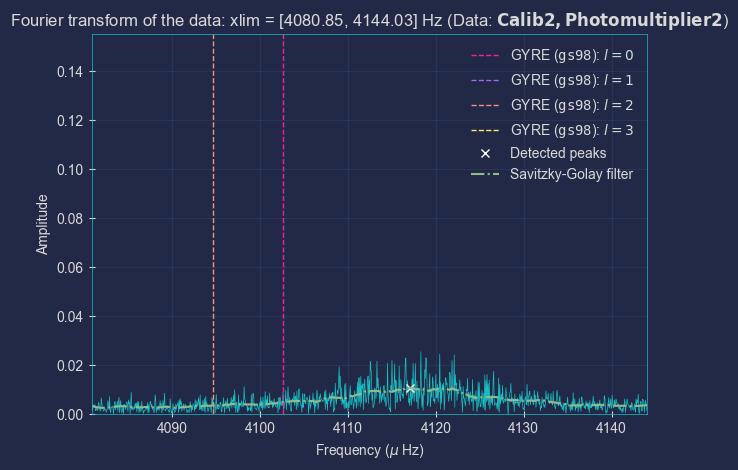

*** Separator ***



MeanY = 0.005198473824795642. xData_window = [4131.448925948508, 4194.632145902009].


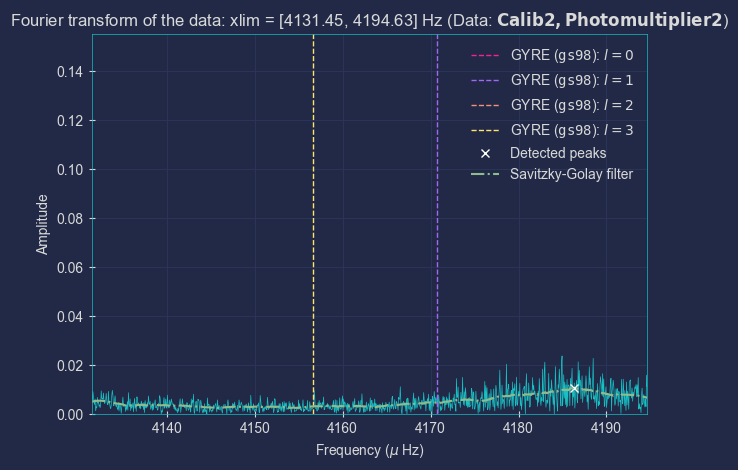

*** Separator ***



MeanY = 0.004953461581342643. xData_window = [4182.046099084445, 4245.229319037946].


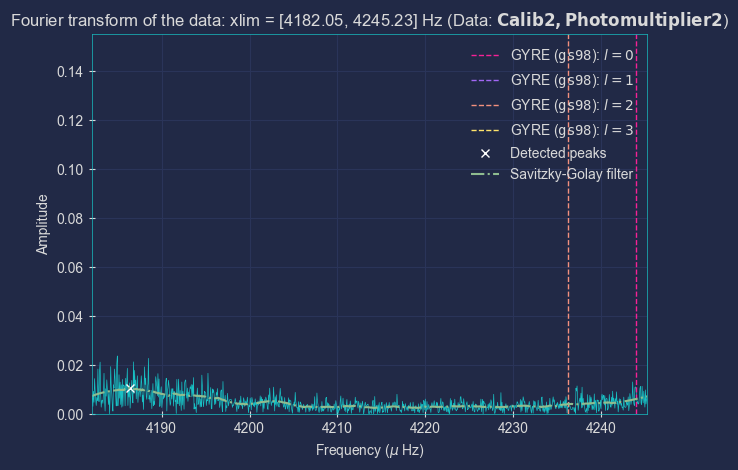

*** Separator ***



MeanY = 0.004572288911717338. xData_window = [4257.94185878835, 4321.125078741851].


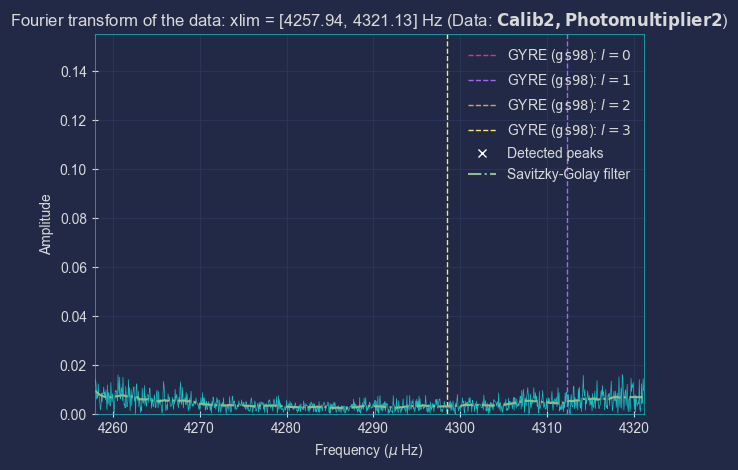

*** Separator ***



MeanY = 0.004960004297280244. xData_window = [4276.915798714326, 4340.099018667827].


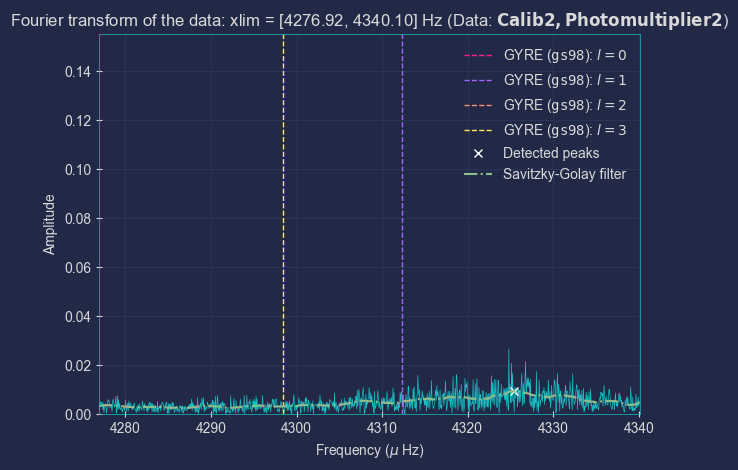

*** Separator ***



MeanY = 0.004600890095458895. xData_window = [4327.512971850263, 4390.696191803764].


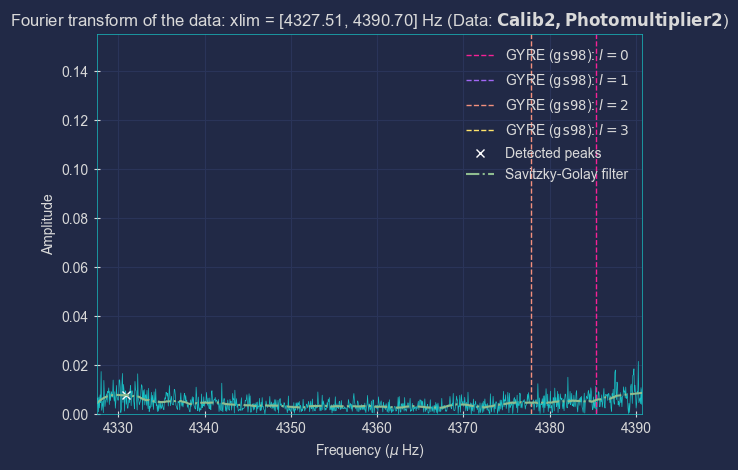

*** Separator ***



MeanY = 0.004417942852757579. xData_window = [4390.759438270185, 4453.942658223686].


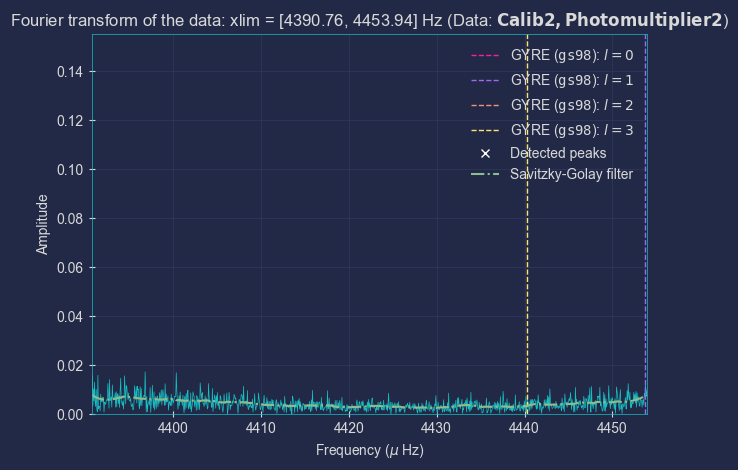

*** Separator ***



MeanY = 0.004297305857221697. xData_window = [4466.65519797409, 4529.838417927592].


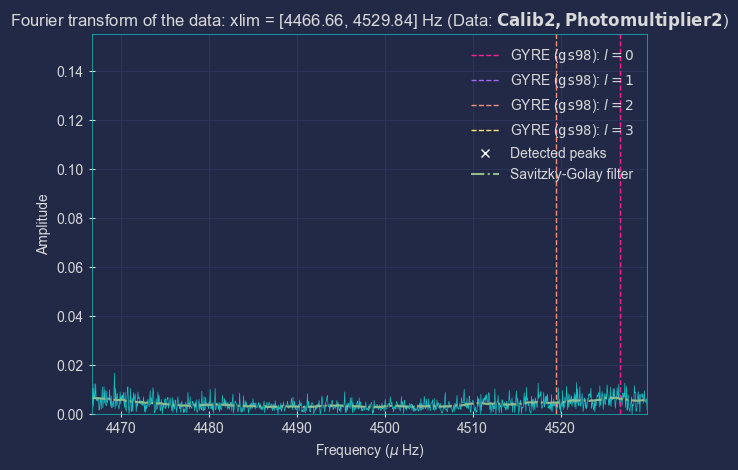

*** Separator ***



MeanY = 0.004376740337115556. xData_window = [4529.901664394011, 4593.084884347512].


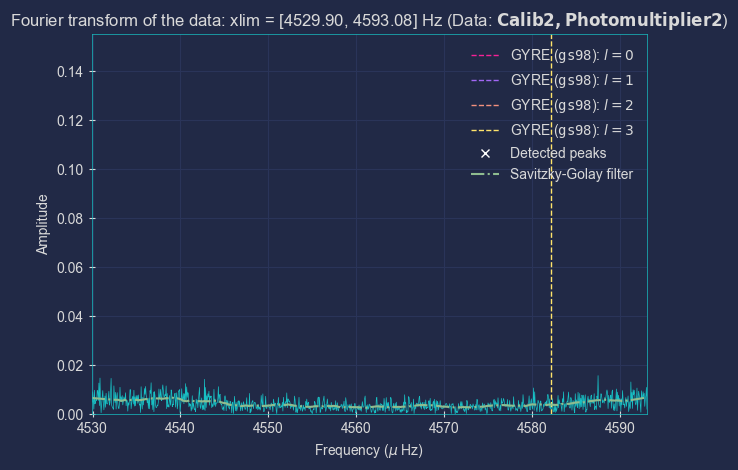

*** Separator ***



MeanY = 0.004245372456442151. xData_window = [4605.7974240979165, 4668.980644051418].


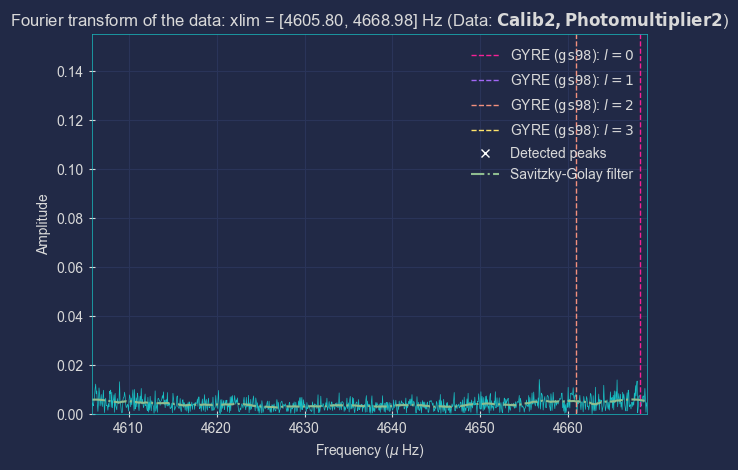

*** Separator ***



MeanY = 0.004091978738022693. xData_window = [4669.043890517838, 4732.227110471339].


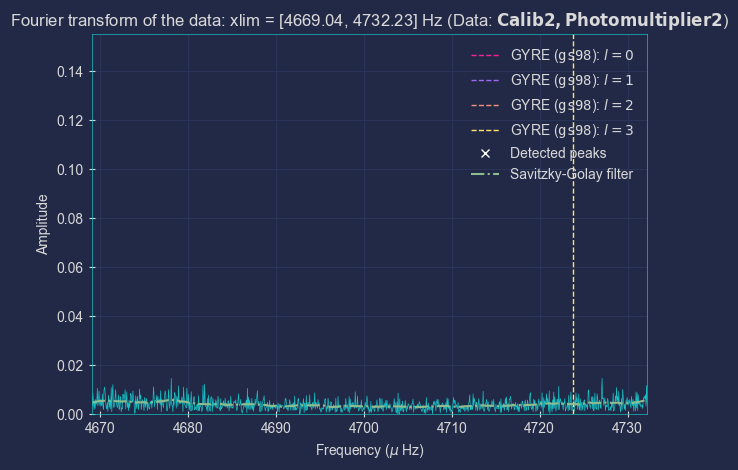

*** Separator ***



MeanY = 0.003983697613917652. xData_window = [4744.939650221743, 4808.122870175244].


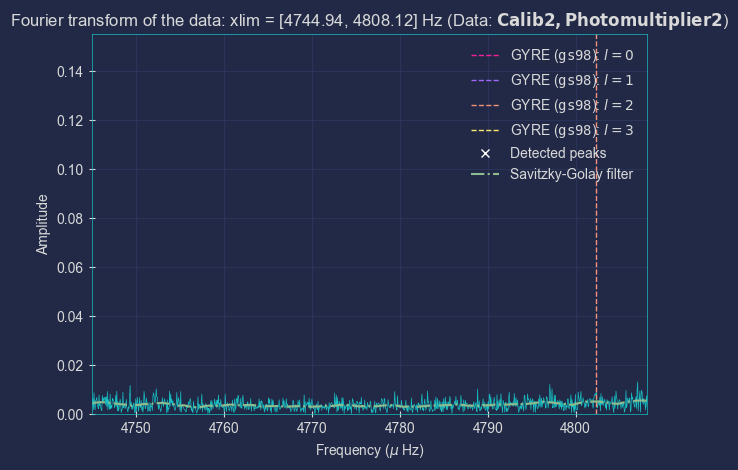

*** Separator ***



MeanY = 0.0038886715645018396. xData_window = [4808.186116641664, 4871.369336595165].


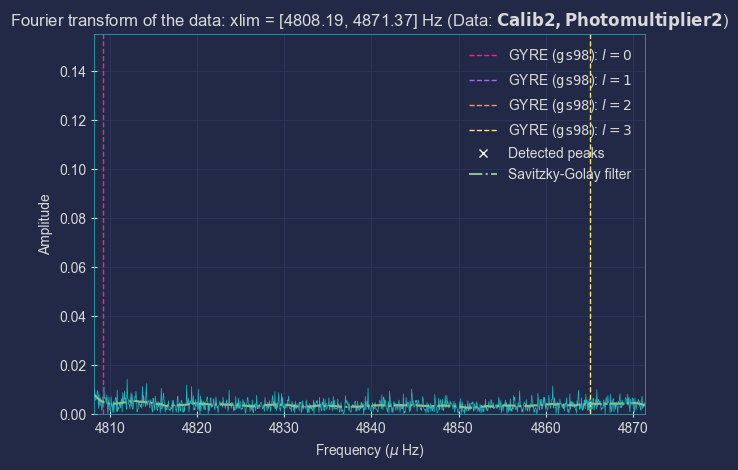

*** Separator ***



MeanY = 0.003924846911519767. xData_window = [4871.432583061585, 4934.615803015086].


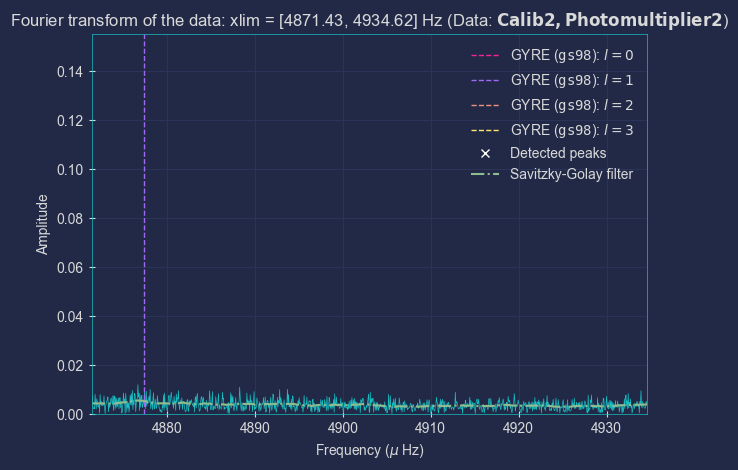

*** Separator ***



MeanY = 0.0038260054879498263. xData_window = [4934.679049481507, 4997.862269435008].


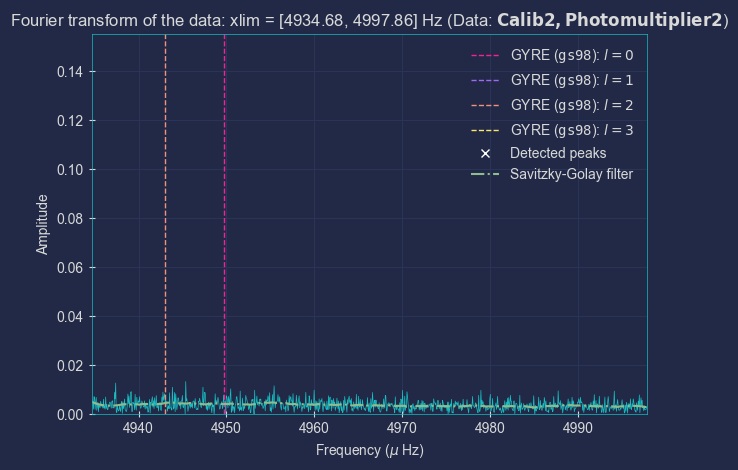

*** Separator ***



MeanY = 0.003686659574162106. xData_window = [5010.574809185412, 5073.758029138913].


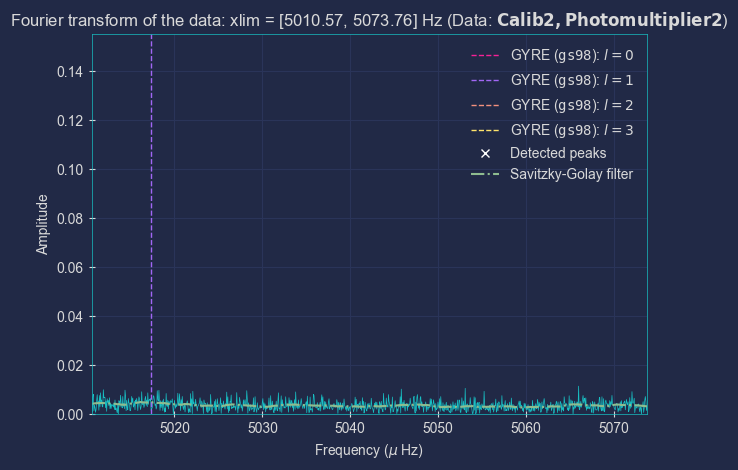

*** Separator ***



MeanY = 0.0035426538991314765. xData_window = [5073.821275605333, 5137.004495558834].


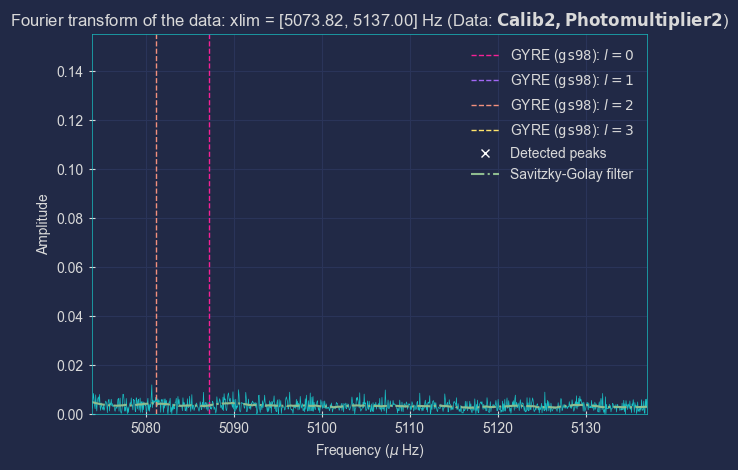

*** Separator ***



MeanY = 0.0034840040636375047. xData_window = [5137.067742025254, 5200.250961978755].


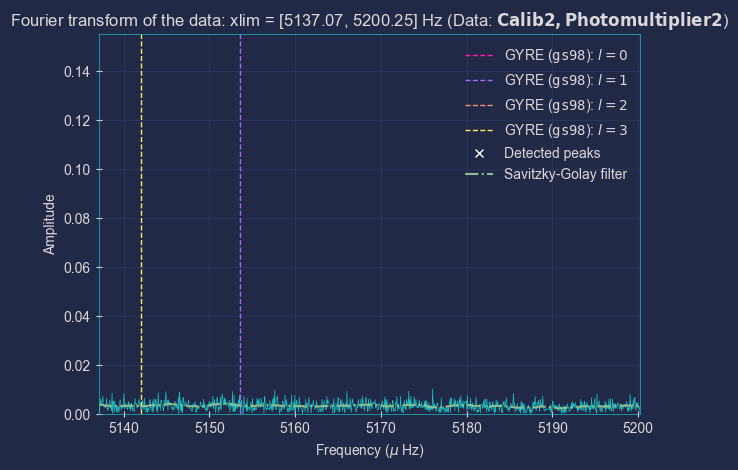

*** Separator ***





In [1951]:
xAll, yAll = xf*1e6, 2.0/N * np.abs(y22f[:N//2])
test_obj = Progressive_Lorentz_Fitter(xAll, yAll, \
                                      l0, l1, l2, l3, \
                                      itSkip = 30, window_size = 1000) # ~63 uHz window size!
test_obj.fit_window()
test_obj.plot_window()
print('*** Separator ***\n\n\n')

for i in range(50):
    test_obj.advance_window()
    test_obj.fit_window()
    test_obj.plot_window()
    print('*** Separator ***\n\n\n')

[MESA/GYRE] Average large separation (Sun) = 135.00362630550697 uHz.
[MESA/GYRE] Average small separation (Sun) = 80.39830225589672 uHz.


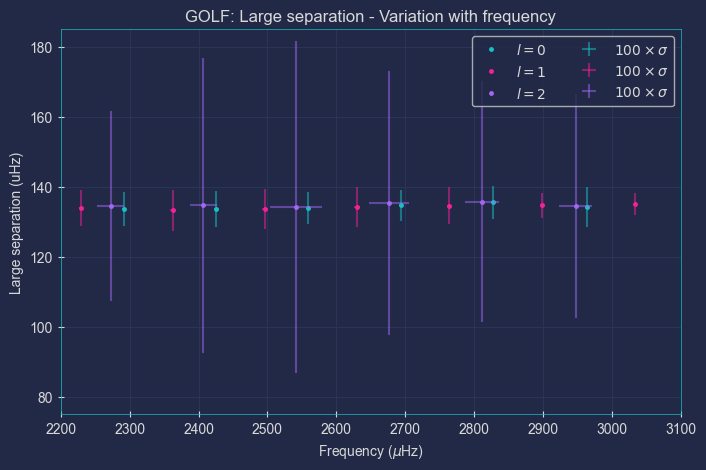

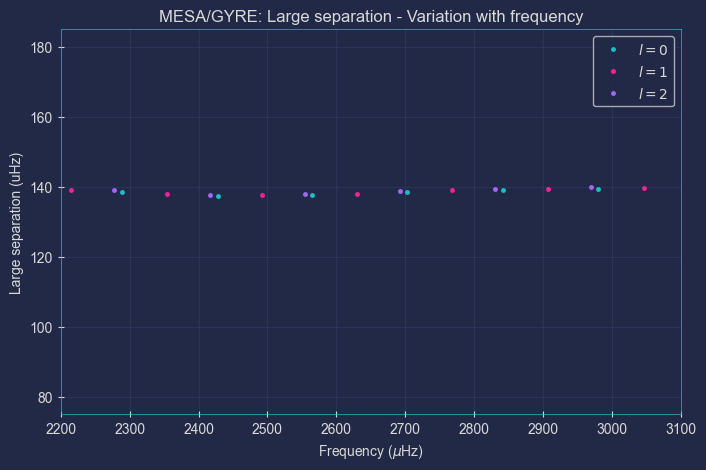

In [1955]:
df = pd.DataFrame(test_obj.freqs, columns = ['Re(freq)', 'Re(freq)_Err', 'l', 'n_p'])
Freqs_GOLF_obj = Stellar_freqs(df)
print(Freqs_GOLF_obj)

# Large separation plots
large_l0_GOLF, large_l1_GOLF, large_l2_GOLF = Freqs_GOLF_obj.large_sep_plot(xlim = (2.2e3, 3.1e3), ylim = (75, 185), title = 'GOLF: Large separation - Variation with frequency', append_name = 'GOLF')
large_l0_MESA, large_l1_MESA, large_l2_MESA = Freqs_MESA_obj.large_sep_plot(xlim = (2.2e3, 3.1e3), ylim = (75, 185), title = 'MESA/GYRE: Large separation - Variation with frequency', append_name = 'MESA_detail')

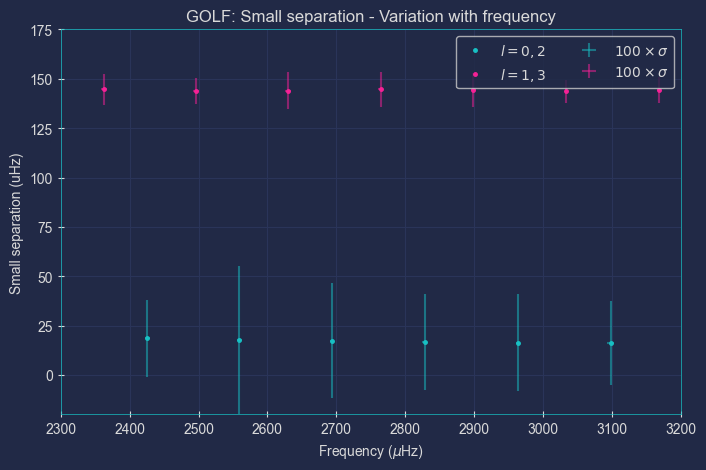

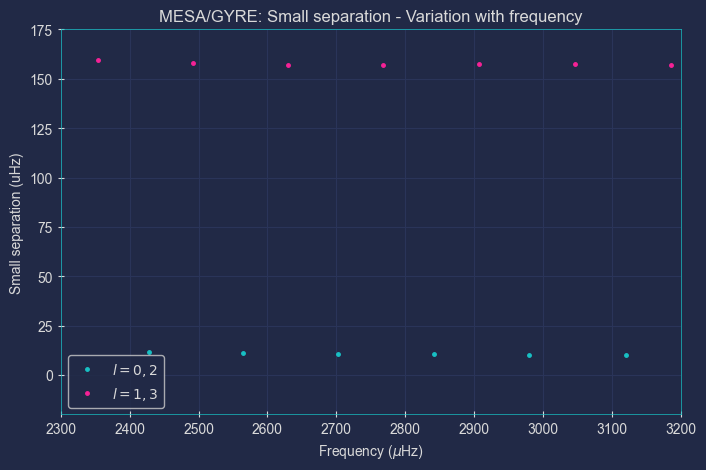

Average small separation: l0 = 17.580 uHz, l1 = 81.040 uHz (GOLF).
Average small separation: l0 = 142.750 uHz, l1 = 213.563 uHz (MESA/GYRE).


In [1956]:
# Small separation plots
small_l0_GOLF, small_l1_GOLF = Freqs_GOLF_obj.small_sep_plot(xlim = (2.3e3, 3.2e3), ylim = (-20, 175), title = 'GOLF: Small separation - Variation with frequency', append_name = 'GOLF')
small_l0_MESA, small_l1_MESA = Freqs_MESA_obj.small_sep_plot(xlim = (2.3e3, 3.2e3), ylim = (-20, 175), title = 'MESA/GYRE: Small separation - Variation with frequency', append_name = 'MESA_detail')

# Comparing the small separations
print(f'Average small separation: l0 = {np.mean(small_l0_GOLF):.3f} uHz, l1 = {np.mean(small_l1_GOLF):.3f} uHz (GOLF).')
print(f'Average small separation: l0 = {np.mean(small_l0_MESA):.3f} uHz, l1 = {np.mean(small_l1_MESA):.3f} uHz (MESA/GYRE).')

This means there's probably a mistake in the identification of the frequencies with the correct $n$ and $l$ values.

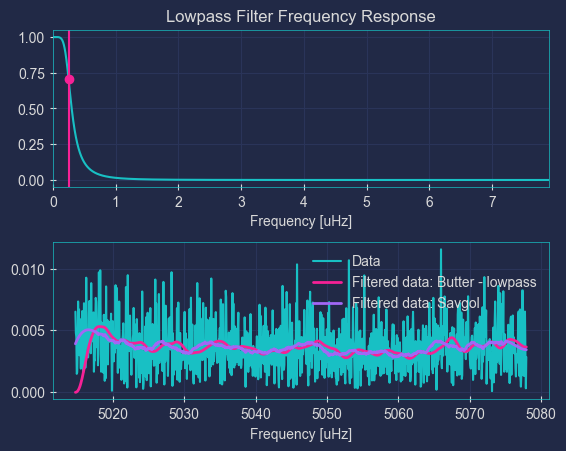

In [1862]:
# Test block
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

xData = test_obj.xData_window
yData = test_obj.yData_window

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 3
fs = 1/(xData[1] - xData[0]) # sample rate, Hz
cutoff = 0.25  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h))
plt.plot(cutoff, 0.5*np.sqrt(2), 'C1o')
plt.axvline(cutoff, color='C1')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [uHz]')

# Demonstrate the use of the filter.
# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(yData, cutoff, fs, order)
yhat = savgol_filter(yData, 90, 3) # window size 51, polynomial order 3

plt.subplot(2, 1, 2)
plt.plot(xData, yData, label='Data')
plt.plot(xData, y, linewidth=2, label='Filtered data: Butter - lowpass')
plt.plot(xData, yhat, linewidth=2, label='Filtered data: Savgol')
plt.xlabel('Frequency [uHz]')
plt.legend()

plt.subplots_adjust(hspace = 0.35)
plt.show()

I'm missing the plot of the large (small) separation as a function of frequency:
- Select, e.g., $l = 0$;
- For $\Delta\nu_{n, l = 0} \equiv \nu_{n+1, l = 0} - \nu_{n, l = 0}$, consider the frequency at mode $n, f_n$
This should be implemented in the `Stellar_freqs` class.

Question: what are the GYRE frequency's uncertainties? How do we obtain them?
Also, I really don't know why my small separation values, for the pair $l = 0, 2$ is so large.

`Creative part: (Tests and examples)`
- Determination of the solar radius from the large separation and speed of sound values. Note: the `csound` value was estimated, by eye, from the sound speed profiles of Part 1. To be more accurate compute the actual sound speed average from these values explicitly.

In [1863]:
csound = 2.5e5 # Approximate
# Solar radius in km
Rsun = 6.957e5
Rsun_Exp = csound/(2*np.mean(large_l0_MESA)*10**-6*1000)
print(f'*** Comparison of the solar radius ***')
print(f'MESA/GYRE:  Rsun = {Rsun_Exp:.3f} km.')
print(f'Literature: Rsun = {Rsun:.3f} km.')
print(f'Rel. error: Rsun = {np.abs(Rsun_Exp - Rsun)/Rsun * 100:.3f} %.')

*** Comparison of the solar radius ***
MESA/GYRE:  Rsun = 589480.741 km.
Literature: Rsun = 695700.000 km.
Rel. error: Rsun = 15.268 %.


- Plot of the large separation $vs$ small separation (there's something wrong here, possible $n_p$ values are mismatched)

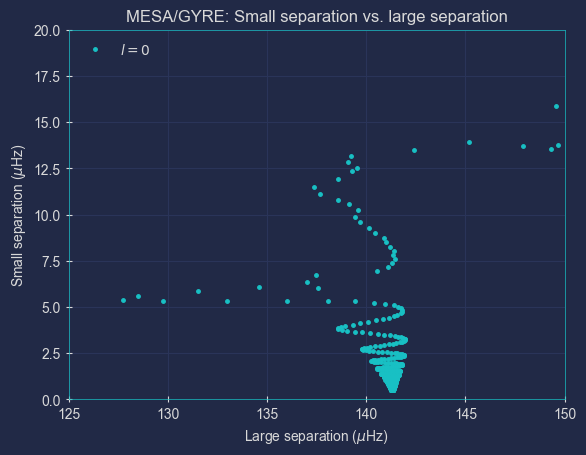

In [1864]:
# Making sure n_p values are matched
matches = []
for i in range(len(small_l0_MESA)):
    for j in range(len(large_l0_MESA)):
        if(int(small_l0_MESA[i][1]) == int(large_l0_MESA[j][1])):
            matches.append((large_l0_MESA[j][0], small_l0_MESA[i][0], int(large_l0_MESA[j][1]), int(small_l0_MESA[i][1])))
            pass
# Plotting results
plt.plot([match[0] for match in matches], [match[1] for match in matches], 'o', markersize = 2.5, color = 'C0', label = r'$l = 0$')
plt.xlim(125, 150)
plt.ylim(0, 20)
plt.xlabel(r'Large separation ($\mu$Hz)')
plt.ylabel(r'Small separation ($\mu$Hz)')
plt.title('MESA/GYRE: Small separation vs. large separation')
plt.legend()
plt.show()